In [1]:
from IPython.display import Latex, Math
from IPython.display import Image

In [2]:
# == T O   H I D E
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 16

#matplotlib.rc('font', size = 22)
#matplotlib.rc('axes', titlesize = 22)

# Entry requirements

We are going to explore the entry requirements to visit a country across the globe. We will find out how easy or difficult to travel from one country from an other. Which are most welcoming and reclusive nation according to what kind of travel documents they demand on entering their territories.


## Preliminaries
### Module
The following modules and tools will be needed:

In [3]:
from collections import Counter
from itertools import chain, count, cycle, islice, product, repeat 
import json

import ete3

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import linkage
import scipy.stats as scs
import scipy.spatial.distance as scd

from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import normalize

### Utility functions 
A handful of helper functions are defined.

In [4]:
def load_dict_from_json(path_to_file):
    """
    Loads a dictionary from a json file
    Parameters:
        path_to_file (str) : **full** path to the json storage
    Returns:
        dict_ ({}) : dictionary
    """
    with open(path_to_file, 'r') as fproc:
        dict_ = json.load(fproc)
    return dict_

In [5]:
def load_df_from_json(path_to_file, orient = 'index'):
    """
    Loads a pandas dataframe from a json file.
    Parameters:
        path_to_file (str) : **full** path to the json storage
        orient (str) : orientation of the json (see pandas.read_json for details)
    Returns:
        df (pandas.DataFrame) : a dataframe
    """
    with open(path_to_file, 'r') as fproc:
        df = pd.read_json(fproc, orient = orient)        
    return df

In [6]:
def most_common(arr):
    """
    Finds the most common element in the array.
    Parameters:
        arr (iterable) : an iterable 
    Returns:
        most_common_element (object) : the most common element in the iterable. In case of ties it returns only on of them.
    """
    counter = Counter(arr)
    most_common_element = counter.most_common(1)[0][0]
    
    return most_common_element

### Coding style
We will tend to use a functional approach for the following reasons:

* It is concise
* It can save memory
* It reflects the transformational nature of data analysis

For example, the `most_common` function would look like 
```
most_common = lambda x: Counter(x).most_common(1)[0][0]
```

In some cases, the code snippets are modestly interesting, hence they are hidden from this post. The raw jupyter notebook can be found here, which contains all of the code used to process the data.

### Graphs
If the script to generate a plot is not particularly insightful it will be omitted. Again, they all can be found here.

## Data collection
The data was collected from the most excellent website [passportindex.org](https://passportindex.org). I would encourage everyone to have a look at the site; one can learn about the (geo)political relationships between countries in a reall entertaining way.

## Preparing the data

### The data

The database is loaded from a `json` storage.

In [7]:
path_to_visa_json_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa\visa_by_country.json'
df_visa = load_df_from_json(path_to_visa_json_db)
df_visa.head(3)

,AD,AE,AF,AG,AL,AM,AO,AR,AT,AU,...,VA,VC,VE,VN,VU,WS,YE,ZA,ZM,ZW
AD,self,visa-free,visa required,visa-free,visa-free,visa-free,visa required,visa-free,visa-free,eTA,...,visa-free,visa-free,visa-free,visa required,visa-free,visa on arrival,visa required,visa-free,visa on arrival,visa on arrival
AE,visa-free,self,visa required,visa required / e-Visa,visa-free,visa-free,visa required,visa-free,visa-free,visa required / e-Visa,...,visa-free,visa-free,visa required,visa required,visa-free,visa on arrival,visa on arrival,visa required,visa on arrival,visa on arrival
AF,visa required,visa required / e-Visa,self,visa required / e-Visa,visa required,visa required,visa required,visa required,visa required,visa required / e-Visa,...,visa required,visa-free,visa required,visa required,visa required,visa on arrival,visa required,visa required,visa required / e-Visa,visa required / e-Visa


The row indices or labels, denote the countries whose citizens are travelling to the countries enumerated in the columns. For example, the (AD, AL) = _visa free_ entry tells us that the citizens of Andorra are granted _visa free_ entry to Albania. A **guest** country is the country one travels from, whereas a **host** country is the country one travels to.  

### Cleaning the data

Firstly, all of the entry requirements are checked. We are looking for 

* aliases 
* mistyped values

A quick histogram binning returns all types of entry requirements:

In [8]:
raw_requirements = Counter(np.ravel(df_visa.values))

for idx, req in enumerate(raw_requirements.most_common()):
    print("{0}\t:  {1}".format(idx, req))

0	:  ('visa required', 18396)
1	:  ('visa-free', 11990)
2	:  ('visa on arrival', 5660)
3	:  ('visa required / e-Visa', 1799)
4	:  ('visa on arrival / eVisa', 537)
5	:  ('eTA', 479)
6	:  ('self', 199)
7	:  ('visitor’s permit', 196)
8	:  ('e-Visa', 153)
9	:  ('eVisa', 100)
10	:  ('Visa waiver on arrival', 80)
11	:  ('eVistors', 5)
12	:  ('EVW', 4)
13	:  ('visa-free ', 3)


It appears electronic visa has two aliases _e-Visa_ and _eVisa_. Also, _visa free_ has a trailing space a few times. The terms _eVistors_ (sic!), _EVW_ are also curious. The following utility `find_in_df` helps us to figure out where these entries appear:

In [9]:
def find_in_df(df, value):
    idcs = []
    for col in df.columns:
        row_idcs = df[df[col] == value].index.tolist()
        idcs.extend([(idx, col) for idx in row_idcs])
    
    return idcs

In [10]:
print("Countries with 'EVW' {0}".format(find_in_df(df_visa, 'EVW')))
print("Countries with 'eVistors' {0}".format(find_in_df(df_visa, 'eVistors')))

Countries with 'EVW' [('AE', 'UK'), ('KW', 'UK'), ('OM', 'UK'), ('QA', 'UK')]
Countries with 'eVistors' [('BG', 'AU'), ('CY', 'AU'), ('CZ', 'AU'), ('HR', 'AU'), ('RO', 'AU')]


* _EVW_ is a form of ETA (ESTA for USA) thus it will be merged into that category. 
* eVistor (eVisitor if spelt correctly) is also a type of ETA so it will also be merged into that category

Looking at _Visa waiver on arrival_ and _visitor’s permit_ reveals that they cover Quatar's and Seychelles' travel requirements.

In [11]:
countries = set([x[1] for x in find_in_df(df_visa, 'Visa waiver on arrival')])
print("Countries with 'Visa waiver on arrival' {0}".format(countries))

countries = set([x[1] for x in find_in_df(df_visa, 'visitor’s permit')])
print("Countries with 'visitor’s permit' {0}".format(countries))

Countries with 'Visa waiver on arrival' {'QA'}
Countries with 'visitor’s permit' {'SC'}


It is worth noting the Seychelles offers universal visa free entry, hence its entries ought to be changed to _visa free_.

The most interesting term _Visa waiver on arrival_ provided to certain national travelling to Qatar is in practice equivalent to _visa free_ travel. It will thus be relabelled as such:

In [12]:
replace_map =  {'EVW' : 'eTA',
                'eVistors' : 'eTA',
                'visa-free ' : 'visa-free', 
                'Visa waiver on arrival' : 'visa-free', 
                'visitor’s permit' : 'visa-free',
                'e-Visa': 'eVisa'}

df_visa.replace(replace_map, inplace = True);

The case where one country explicitly bars specific nationals to enter her territory is missing from the original database. They can be compiled from [this wikipedia site](https://en.wikipedia.org/wiki/List_of_nationalities_forbidden_at_border). The citizens are the keys the values are the lists of countries from which they are barred from in the dictionary below. (Can the reader find out which country bans Taiwan?)

In [13]:
barred_countries = {"AM" : ["AZ", "PK"],  "BD" : ["SD", "LY"], "VE" : ["US"], "TD" : ["US"],
                    "IR" : ["US", "LY"],  "LY" : ["US"], "SY" : ["US", "LY", "ML"],"YE" : ["US", "LY"],
                    "PK" : ["LY"],"SD" : ["LY"], "KP" : ["KR", "JP"],
                    "SO" : ["AU","NZ","FI", "SE", "DE", "NO", "CA", "SK", "CZ", "HU", "GR", "LU", "NL", "UK", "US"],
                    "QA" : ["LY", "AE", "SA"], "TW" : ["GE"],
                    "RK" : ["AM", "AZ", "BY", "KZ", "KG", "MD", "RU", "TJ", "TM", "UA", "UZ", "CU", "GE", "SC"],
                    "IL" : ["IR","KW","LB","LY","SA","SY","YE","IQ","MY","DZ","BD","BN","OM","PK","AE"]}

In [14]:
for guest, hosts in barred_countries.items():
    for host in hosts:
        df_visa.loc[guest, host] = 'barred'

A quick check shows all substitutions have been performed correctly.

In [15]:
requirements = Counter(np.ravel(df_visa.values))

for idx, req in enumerate(requirements.most_common()):
    print("{0}\t: {1}".format(idx, req))

0	: ('visa required', 18341)
1	: ('visa-free', 12268)
2	: ('visa on arrival', 5658)
3	: ('visa required / e-Visa', 1791)
4	: ('visa on arrival / eVisa', 537)
5	: ('eTA', 488)
6	: ('eVisa', 253)
7	: ('self', 199)
8	: ('barred', 66)


The cleaned data are then saved.

In [16]:
path_to_visa_clean_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa_by_country_clean.json'
df_visa.to_json(path_to_visa_clean_db, orient = 'index')

### Preparation

There is wide range of possibilities to explore. If the reader is interested in 1D statistics, such as which is the most welcoming country he is referred to the [passport.org](https://www.passportindex.org/)  website.

#### Encoding

We are dealing with categorical values therefore one can assign an integer number to each category. They are also ordered, in a sense, based on how restricted the entry to a certain country is. One can attemp to create a mapping that represents the various levels of freedom. Albeit, it will be slightly subjective.

In [17]:
requirement_order_map = {'self' : -1, 
                         'visa-free' : 0, 
                         'eTA' : 1,
                         'visa on arrival' : 2,
                         'visa on arrival / eVisa' : 3,
                         'eVisa' : 4,
                         'visa required / e-Visa' : 5,
                         'visa required' : 6, 
                         'barred' : 7}
category_lookup = dict(zip(requirement_order_map.values(), requirement_order_map.keys()))
_ = category_lookup.pop(-1)

This mapping is applied to the clean database:

In [18]:
path_to_visa_clean_db = r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa_by_country_clean.json'
df_visa_clean = load_df_from_json(path_to_visa_clean_db)
df_visa_clean.replace(requirement_order_map, inplace = True)

Two lookup tables are generated to facilitate to match the country labels and names to the indices:

In [19]:
cnt_code_lookup = dict(enumerate(df_visa_clean.index)) # index --> country code

code_name_dict = load_dict_from_json(r'C:\Users\Balazs\Desktop\bhornung_movies\yemen2018\visa\ccodes.json')
cnt_name_lookup = {_k : code_name_dict[_v] for _k, _v in cnt_code_lookup.items()} # index --> country name

Finally, colourmaps are created to encode the entry categories.

In [20]:
cat_colors = ['#405da0', '#3189b2', '#45935d', '#a5ea85', '#e2f28c', '#edc968', '#bc6843', '#474543']
cat_colors_aug = ['#000000', '#405da0', '#3189b2', '#45935d', '#a5ea85', '#e2f28c', '#edc968', '#bc6843', '#474543']
cat_cmap = ListedColormap(cat_colors)
cat_cmap_aug = ListedColormap(cat_colors_aug)

### Terminology

It is worth introducing the following terminology and notation.

* The number of countries is denoted by $n_{g}$ (_g_ refers to _guest_)
* The entry requirements are categories hence the full set of them is denoted by

   $C \text{, where } C =\bigcup\limits_{k=0} c_{k}$ where $c_{k}$ is an entry category such as _visa free_.

* The table containing the entry requirements is called _voting table_ and is denoted by 

    $V \in C^{n_{g} \times n_{g}}  \iff V_{ij} \in C$, where the first index, $i$, in the guest country the second index, $j$, is the host country. $V$ is symmetric only if each pair of countries have reciprocal entry requirements.
   
* The _i_-th row of $V$ is denoted by $v_{i,*}$ which represents the entry requriments for a citizen of country _i_. Likewise,
* The _i_-th column of $V$ is denoted by $v_{*,i}$ which represents requirements demanded by country _j_  

In [21]:
V = df_visa_clean.values
ng = V.shape[0]
nc = len(requirement_order_map) - 1 # ignore `self`

## Analysis

### General observations

The entropy, $H$ measures the information content or randomness of a distribution. The higher it is the less likely one can predict which value will be observed next from the distribution of interest. Entropy has a lower bound of zero, however, in general, it does not have a constant upper bound. The entropy of the distribution of categories equals
$$
H(C) = \sum\limits_{i=1}^{|C|} - p(c_{i}) \log(p(c_{i})) \text{,  where}
$$
$p$ is the probabiblity density function of $C$.

Should all countries have random requirements, the entropy would be maximal for the entire table and for each country:
$$
    H_{max}(C) = \sum\limits_{i}^{|C|} - \frac{1}{|C|} \log\frac{1}{|C|} = - log(|C|).
$$

We can then define the following relative entropies, with upper bound of unit:

The relative overall entropy: $H_{t} = H(V) / H_{max}(C)$ 

relative guest entropy: $H_{g}(i) = H(v_{i,*}) / H_{max}(C)$ 

relative host entropy:  $H_{h}(i)= H(v_{*,i}) / H_{max}(C)$ are defined to investigate the diversity of distribution.

In [22]:
max_entropy = np.log2(nc)
get_frequencies = lambda x: np.unique(x[x != -1], return_counts = True)[1]

# all countries
overall_entropy = scs.entropy(get_frequencies(V)) / max_entropy

# guest countries
guest_entropy = np.fromiter((scs.entropy(get_frequencies(g)) for g in V), dtype = np.float, count = ng) / max_entropy

# host countries
host_entropy = np.fromiter((scs.entropy(get_frequencies(h)) for h in V.T), dtype = np.float, count = ng) / max_entropy

print("Entropy of requirements for all countries: {0:5.3f}".format(overall_entropy))

Entropy of requirements for all countries: 0.431


The joint distribution of the host and guest entropies are shown below. (I prefer to use scatter plot along with kde-type plots as the latter ones can be misleading sometimes, especially violin plots.)

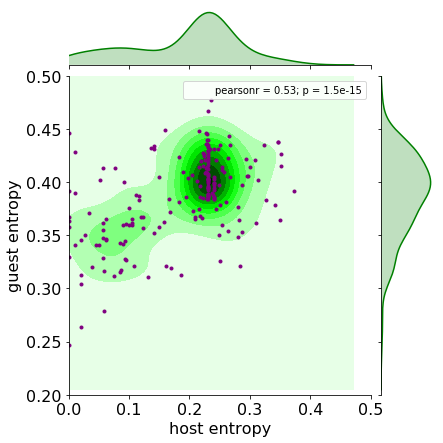

In [23]:
# === T O  H I D E

ax = sns.jointplot(host_entropy, guest_entropy, kind = 'kde', color = 'green', xlim = (0.0, 0.5), ylim = (0.2, 0.5))
ax.x = host_entropy; ax.y = guest_entropy;
ax.set_axis_labels("host entropy", "guest entropy")
ax.plot_joint(plt.scatter, marker = '.', c = 'purple')
plt.show()

It is immediately seen that countries do not have random requirements, for the maximum entropy is around 0.4. On the contrary, each country is biased towards certain requirements. The guest entropy never hits its lower bound, indicating each country has at least two exit requirements. The countries whose host requirement is zero demand the same documents from all incoming citizens. There are around ten of them. However, the entropy _does not_ state anything about the _values_ of the random variate. A quick sorting (pun intended) tells which ones these are.

The statistics of the countries will be collected in the `df_cnt_stats` dataframe.

In [24]:
df_cnt_stats = pd.DataFrame({'code' : df_visa_clean.index})
df_cnt_stats['name'] = df_cnt_stats['code'].apply(lambda x: code_name_dict[x])
df_cnt_stats['guest_entropy'] = guest_entropy
df_cnt_stats[ 'host_entropy'] = host_entropy
df_cnt_stats['most_common_entry'] = [category_lookup[most_common(h)] for h in V.T]
df_cnt_stats['most_common_exit'] = [category_lookup[most_common(g)] for g in V]

In [25]:
# there is a weird bug in nsmallest and nlargest so we use sort_values instead
df_cnt_stats.sort_values(by=['host_entropy'])[['name', 'host_entropy', 'most_common_entry']].head(10) 

,name,host_entropy,most_common_entry
57,MICRONESIA,0.000000,visa-free
111,MADAGASCAR,0.000000,visa on arrival
2,AFGHANISTAN,0.000000,visa required
121,MALDIVES,0.000000,visa on arrival
92,NORTH KOREA,0.000000,visa required
90,COMOROS,0.000000,visa on arrival
163,SOMALIA,0.000000,visa on arrival
44,DJIBOUTI,0.010582,visa on arrival
46,DOMINICA,0.010582,visa-free
154,SEYCHELLES,0.010582,visa-free


Indeed, uniform requirement for a country does not mean identical requirements across countries as we can see _visa free_, _visa required_ and other categories. 

### Distribution of requirements

#### Host and guest scores

A crude estimation of how welcoming a country can be expressed as the mean of the her entry requirements. This will be called the _host score_, $s_{w}$.

$$
s_{h}(i) = \frac{ \sum\limits_{j \neq i} v_{ji} } {n_{g} - 1}
$$
Likewise, the average of the exit requirements of a country will be called the guest score, $s_{g}$ and indicates how welcomed the citizens of that country are.
$$
s_{g}(i) = \frac{ \sum\limits_{j \neq i} v_{ij} } {n_{g} - 1}
$$

In [26]:
sh = (V.sum(axis = 0) + 1) / (ng - 1)
sg = (V.sum(axis = 1) + 1) / (ng - 1)

The score distribution is shown below. 

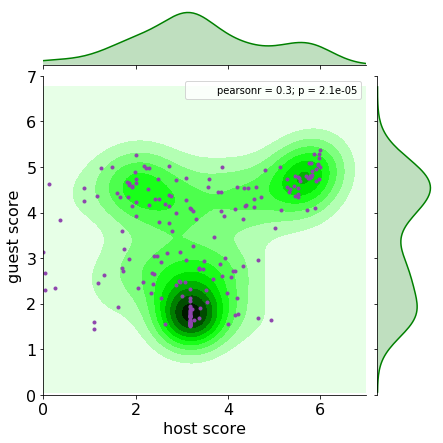

In [27]:
# === T O  H I D E

ax = sns.jointplot(sh, sg, kind = 'kde', color = 'green', xlim = (0.0, 7.0), ylim = (0.0, 7.0))
ax.x = sh; ax.y = sg;
ax.set_axis_labels("host score", "guest score")
ax.plot_joint(plt.scatter, marker = '.', c = '#8E44AD')
plt.show()

The histogram of the host and guest score plot hints at three major types of mutual relationships. Agglomerate of countries in the upper right corner indicates mutally restricted entry criteria. The bottom middle region of the graph groups countries that have mixed entry requirements but, in general, one can enter other countries reasonbly easily. The top left cluster represents welcoming countries whose citizens face strict entry requirements. 

### Distribution of requirements

The distribution of exit requirements _i.e._ documents required from a country, $\mathbf{p}_{g}(i) \in \mathbb{R}^{n_{g} \times |C|}$, _i.e._ histogram of the columns reflects how permissive a country is.

$$
p_{g}(i)_{j} = \frac{ \sum\limits_{ k\neq i} \delta(v_{ki}, c_{j}) } {n_{g} - 1 }
$$

In [28]:
pg = np.zeros((ng, nc))
count_gen = (np.unique(v, return_counts = True) for v in V)

for row, (idcs, count_) in zip(pg, count_gen): # blessed be passing references
    row[idcs[:-1]] = count_[:-1]
    
pg = pg / pg.sum(axis = 1)[:, None]

The distributions for Azerbaijan, Central African Republic, Cameroon, Cape Verde, Bhutan, DR Congo, Belgium and The Netherlands are show below. It is readily observed the first six countries are easier to travel from as to how much paperwork is needed compared to the last two ones. A question then naturally arises whether are there groups of countries of similar requirement patterns?

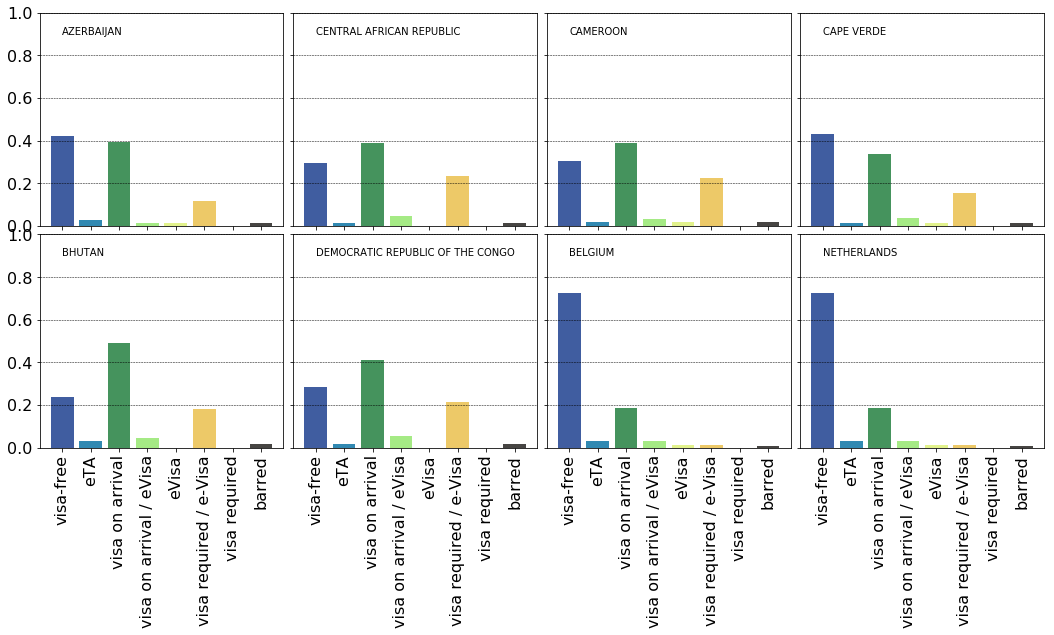

In [29]:
# === T O  H I D E

sel = [10, 30, 35, 40, 24, 29, 14, 130]

fig, axes = plt.subplots(2,4, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(18,8)
for ax, idx in zip(axes.flat, sel):
    
    ax.bar(range(nc), pg[idx], color = cat_colors)
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
#
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.text(0, 0.9, cnt_name_lookup[idx])
    
plt.show()

As a start, we can now easily figure out which country has the most polar exit requirements. The term 'polar' means separated bimodal distribution:

* there are two categories that are more likely than any other $\forall m \in C / \{k, l\} : p_{g}(i)_{k/l} > p_{g}(i)_{m} $
* their probabilities are close to each other: $p_{g}(i)_{k} \approx p_{g}(i)_{l}$
* their separation is larger than half of the cardinality of the categories: $|k - l| \geq \frac{|C|}{2}$

A limiting case is where two categories have 0.5 and 0.5 probabilties. Based on the previous plots these categories are likely to be _visa free_, _visa on arrival_ and _visa required_.

In [30]:
mask = np.zeros((3, nc), dtype = np.float)
mask[0,0] = mask[0,6] = 0.5           # visa free -- visa required
mask[1,0] = mask[1,2] = 0.5           # visa free -- visa on arrival
mask[2,2] = mask[2,6] = 0.5           # visa on arrival -- visa required
overlap = np.linalg.norm(pg[:,None,:] - mask, axis = 2)
bimodals = np.array([np.argsort(x)[:3] for x in overlap.T])

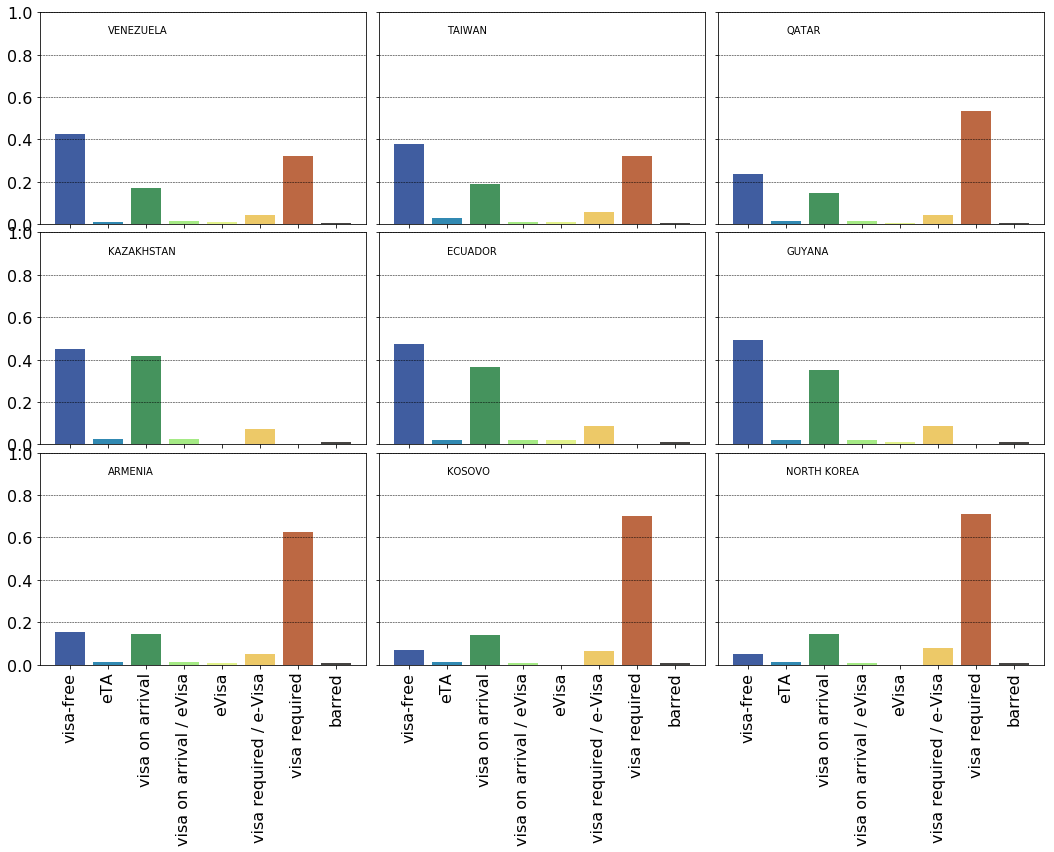

In [31]:
# === T O  H I D E

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(18,12)
for idx, ax in zip(bimodals.flat, axes.flat):

    ax.bar(range(nc), pg[idx], color = cat_colors)
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
#
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.text(1.0, 0.9, cnt_name_lookup[idx])

plt.show()

Each row of the plot above shows the three most polar distribution of requirements for the _via free_ - _visa required_, _visa free_ - _visa on arrival_ and _visa on arrival_ - _visa required_ pairings.  

### Comparison of requirements 

The distributions of the countries are compared _via_ the Euclidean distance matrix, $D \in \mathcal{R}^{n_{g}\times n_{g}}$.
$$
d_{ij} = \| \mathbf{p}_{h}(i) - \mathbf{p}_{h}(j) \|^{2}_{2}
$$

In [32]:
dist_mat = scd.squareform(scd.pdist(pg))

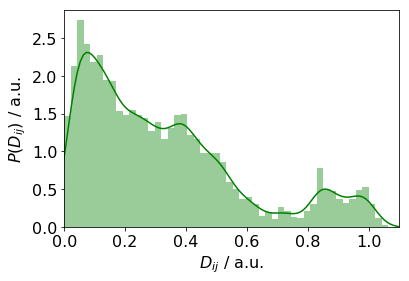

In [33]:
# === T O  H I D E

ax = sns.distplot(dist_mat.flat, kde = True, color = 'green')
ax.set_xlim((0.0, 1.1))
ax.set_xlabel(r'$D_{ij}$ / a.u.')
ax.set_ylabel(r'$P(D_{ij})$ / a.u.')
plt.show()

If  there are $n$ clusters of similar $P_{g}$-s, then the maximum number of peaks in the distance plot is 
$
\begin{equation}
    \begin{pmatrix}
          n \\
          2
    \end{pmatrix}
     + 1
\end{equation}
$.
There are about between 4 and  7 peaks in the plot above. This implies the number of clusters is 3 or 4. However, one cannot tell the which countries are in a certain cluster. In order to reveal this, we will group the $P_{g}(i)$ distributions for all countries. Firstly, we calculate the [Ward linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) between the individual distributions. The number of clusters is then chosen. The following options are given:

1. Perform a number of consecutive clusterings then choose the one where the _intra_ cluster variance is below a certain limit with the maximum number of clusters.
1. Calculate the linkage matrix, $Z$ and plot the _inter_ cluster distance. The number of subgraphs to keep is deduced by the location from the largest gap between the successive _inter_ cluster distances (see below).
1. Calculate the linkage matrix and calculate the _intra_ cluster distance in a breadth first traversal. Stop the traversal when the distance drops below a certain limit. This would save us from the computational burden of performing consecutive clustering thus assembling the same linkage matrix over and over again. 

In [34]:
Z = linkage(pg, 'ward')

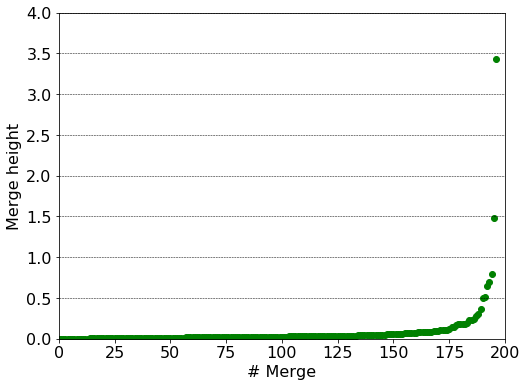

In [35]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.scatter(range(Z.shape[0]),Z[:,2], c = 'green')
ax.set_xlabel('# Merge')
ax.set_ylabel('Merge height')
ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
ax.set_xlim((0,200))
ax.set_ylim((0, 4))
plt.show()

In the plot above each point corresponds to a merge. The merge height is also an upper bound for the intra cluster variance of the joined clusters. We therefore use method \#1 to determine the number of clusters. The largest gap is between the penultimate point and the one before it, thus we will have three clusters. 

In the following we create a circular dendrogram of the clusters. 

In [36]:
# === T O  H I D E

def split_at_n_top(X, n):
    """
    Splits a linkage matrix yielding given number of clusters as a dictionary.
    Parameters:
        X (scipy sparse linkage matrix) : linkage matrix
        n (int) : number of clusters to keep
    Returns:
        clusters ({int : [int]}) : cluster index -- cluster members dictionary
    """
 
    if n == 0:
        raise ValueError("Number of clusters must be positive. Got: {0}".format(n))
    elif n == 1:
        clusters = {0 : np.arange(X.shape[0] + 1)}
        return clusters
    
# arithmetics
    n_leaves = X.shape[0] + 1              # number of leaves
    n_keep_levels = n  - 1                 # boo
    idx_max = 2 * X.shape[0] + 1           # maximum cluster index
    
# choose topmost n merges
    idcs = {int(x) for x in np.ravel(X[-n_keep_levels:, :2])}

# remove those cluster indices which are split
    split_cluster_idcs = set(range(idx_max - n_keep_levels, idx_max))
    
# remove leaves
    root_node_idcs = list(filter(lambda x: x >= n_leaves, idcs - split_cluster_idcs))
    leaf_nodes = list(filter(lambda x: x < n_leaves, idcs - split_cluster_idcs))

    # traverse all subgraphs
    clusters = {}
    
    arr_selector = lambda x, cond, arr1, arr2: arr1.append(x) if cond else arr2.append(x)
    
    for cluster_idx, root_node_idx in enumerate(root_node_idcs):
        queue, leaves = [], []
        queue.append(root_node_idx)
   
        while len(queue) > 0:
            curr = queue.pop(0)

            cl = int(X[curr - n_leaves, 0])
            cr = int(X[curr - n_leaves, 1])

            arr_selector(cl, cl >= n_leaves, queue, leaves)
            arr_selector(cr, cr >= n_leaves, queue, leaves)
         
        clusters.update({cluster_idx : np.array(leaves, dtype = np.int)})
        
    # add singleton clusters
    for idx, node in enumerate(leaf_nodes):
        idx_ = idx + cluster_idx + 1
        clusters.update({idx_ : np.array([node])})
        
    return clusters

In [37]:
# === T O  H I D E

def clusters_to_labels(clusters):
    """
    Given a dictionary of clusters it returns the 1D label array.
    Parameters:
        clusters ({int : [int]}) : cluster index -- cluster members dictionary
    Returns:
        labels (np.ndarray) : label of each point according to its cluster membership
    """
    n_points = sum(map(lambda x: x.size, clusters.values()))
    labels = np.zeros(n_points, dtype = np.int)
    
    for cluster_idx, idcs in clusters.items():
        labels[idcs] = cluster_idx
        
    return labels

In [38]:
def linkage_to_labels(X, n):
    """
    Tranforms a scipy style linkage matrix to a list of labels.
    Parameters:
        X (scipy sparse linkage matrix) : linkage matrix
        n (int) : number of clusters to keep
    Returns:
        labels (np.ndarray) : label of each point according to its cluster membership
    """
    clusters = split_at_n_top(X, n)
    labels = clusters_to_labels(clusters)
    return labels

The dendrogram is split to three clusters:

In [39]:
clustaz = split_at_n_top(Z, 3)

The means and variance of the requirement distributions are then calculated:

In [40]:
means = np.array([np.mean(pg[_v], axis = 0) for _k, _v in clustaz.items()])
stds = np.array([np.std(pg[_v], axis = 0) for _k, _v in clustaz.items()])

The three groups correspond to the most welcomed ones, _e.g._ as those in the EU, welcomed ones, such as many Asian and African countries. The third groups consists of countries with strained international relationships (Armenia) or ones with serious internal conflicts (Syria).  

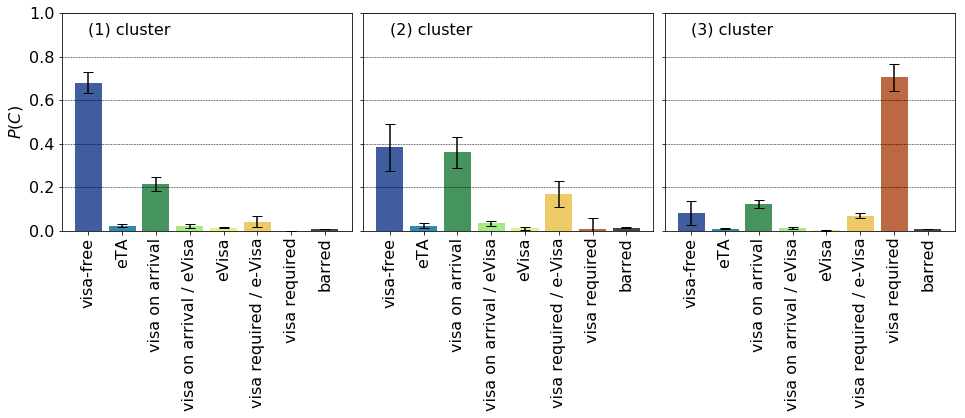

In [41]:
# === T O  H I D E

fig, axes = plt.subplots(1, 3, sharey = True, gridspec_kw = {'wspace' : 0.04})
fig.set_size_inches(16,4)

for idx, (mean, std, ax) in enumerate(zip(means, stds, axes.flat)):
    
    ax.bar(range(mean.shape[0]), mean, yerr = std, capsize = 5, color = cat_colors)
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    
    ax.set_xticks(range(8))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.text(0, 0.9, "({0}) cluster".format(idx + 1), fontsize = 16)
axes[0].set_ylabel(r'$P(C)$') 
plt.show()

The dendrogram shows these clusters and the base distributions from which the distances were calculated, in anticlockwise order.

show picture

## Mutual requirements

We turn our attention to the two way relationships ebodied in the requirements.


### Reciprocity
Firstly, we investigate the reciprocity of requriments. To this end we pair, the $i \rightarrow j$ and $j \rightarrow i$ requirements and make a histogram of the pairs. The resulting matrix is called reciprocity matrix, $R$:

$$
\begin{eqnarray}
R & \in & \mathbb{N}^{|C| \times |C|} \\
r_{ij} & = & \sum\limits_{k<l} \delta(v_{kl}, c_{i}) \cdot \delta(v_{lk}, c_{j})
\end{eqnarray}
$$

In [42]:
tril = chain(*map(lambda x: zip(repeat(x-1, x), range(x)), range(ng, 1, -1)))         # generator for lower triangle indices
recip_histo = Counter(map(lambda x: (V[x[1], x[0]], V[x[0], x[1]]), tril))            # count tuples

recip_mat = np.zeros((nc, nc), dtype = np.float)                                      # convert to np.ndarray
for idcs, count_ in recip_histo.items():
    recip_mat[idcs] = count_ 
recip_mat = recip_mat / np.sum(recip_mat)

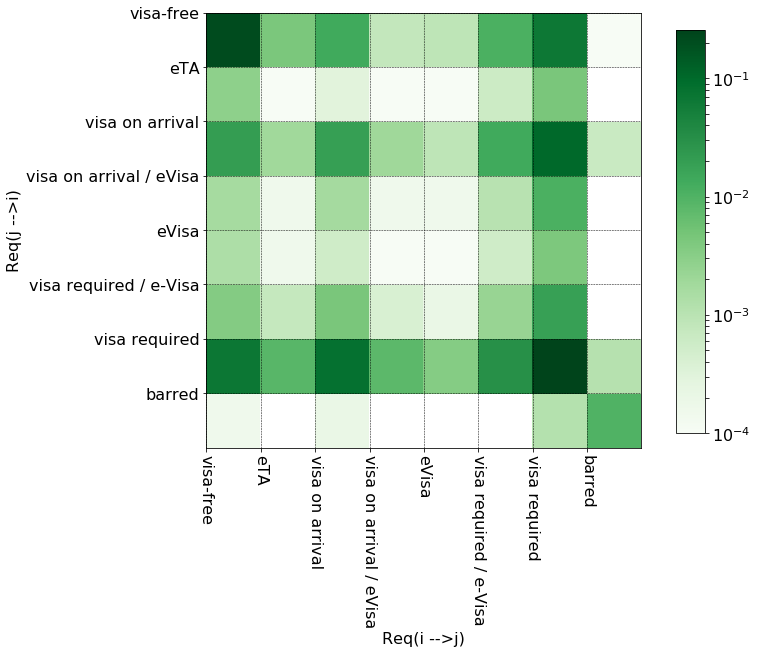

In [43]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
im = ax.imshow(recip_mat, cmap = 'Greens', norm = LogNorm(vmin = 0.0001))

ax.set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

ax.set_xticklabels(category_lookup.values(), rotation = -90)
ax.set_yticklabels(category_lookup.values())

ax.xaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)
ax.set_xlabel("Req(i -->j)"); ax.set_ylabel("Req(j -->i)");
plt.show()

The matrix is not symmetric meaning that there are pairs of countries which demand different travel documents depending on the direction of travel. The most popular mutual requirements are 

* **(0,0)** is the number of cases where entry from _i_ to _j_ is _visa free_ and entry from _j_ to _i_ is _visa free_ too
* **(0,6)** is the number of cases where entry from _i_ to _j_ is _visa free_ and entry from _j_ to _i_ _requires a visa_
* likevise **(6,0)** is the number of cases where entry from _i_ to _j_ _requires a visa_ and entry from _j_ to _i_ is _visa free_
* **(2,6)** and **(6,2)** are popular categories where _visa on arrival_ is expected for a _visa_ 

The ratio of the identical requirements, `r_req_iden` is the trace of the matrix.

In [44]:
r_req_iden = np.trace(recip_mat) 
print("Ratio of mutually identical entry requirements: {0:.4f}".format(r_req_iden))

Ratio of mutually identical entry requirements: 0.4997


#### Comparing countries by reciprocity patterns

In oder to compare individual countries, their reciprocity matrices, $R^{(k)} \in \mathbb{R}^{n_{c} \times n_{c}}$, have to be calculated.

$$
r^{(i)}_{kl} = \frac{ \sum\limits_{j \neq i} \delta(c_{k},v_{ij}) \cdot \delta(c_{l}, v_{ji})} {n_{g} - 1}
$$

The reciprocity matrix, $R$ defined earlier is the sum of the individual reciprocity matrices:

$$
    R = \sum\limits_{i} R^{(i)}
$$

The few lines below conveniently do this job:

In [45]:
cnt_recip_mat = np.zeros((ng, nc, nc), dtype = np.float)

for idx, (g, h) in enumerate(zip(V, V.T)):                         # make pairs
    count_dict = dict(Counter(zip(g, h)))                          # count pairs of requirements
    _ = count_dict.pop((-1, -1), None)                             # remove (-1, -1) if present
                                                        
    for (r, c), count_ in count_dict.items():                       # populate matrix
        cnt_recip_mat[idx, r, c] = count_

cnt_recip_mat = np.reshape(cnt_recip_mat, (ng, nc * nc))
normalize(cnt_recip_mat, norm = 'l1', axis = 1, copy = False);

A way to identify repeating patterns is to perform a PCA analysis. There are, however, two issues with PCA. Firstly, it only accounts for linear dependencies, secondly it only looks at linear transformation of the data. Nevertheless, it recovers some basic relationships.

In [46]:
pca = PCA();
pca.fit(cnt_recip_mat)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We are going to the first few principal components that account for the 95% of the total variance.

In [47]:
evr = pca.explained_variance_ratio_
cevr = np.cumsum(evr)
keep_idcs = np.arange(64, dtype = np.int)[cevr < 0.95]
print(keep_idcs)

[0 1 2 3 4 5]


Only six components are retained out of sixty four. It is inetersting to see that most of the linear relationships involve the _visa required_ restriction. For example, the first component (top left corner) indicates that a pair of countries either has (_visa required_, _visa on arrival_) **xor** (_visa required_, _visa required_) mutual requirements.

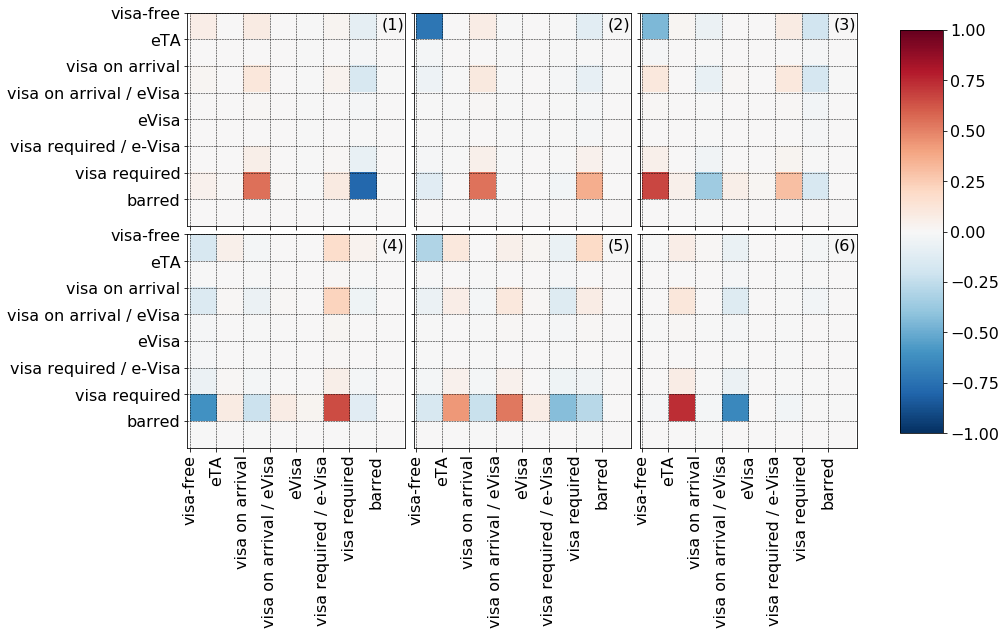

In [48]:
# === T O  H I D E

fig, axes = plt.subplots(2,3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(12,8)
for idx, (ax, comp) in enumerate(zip(axes.flat, pca.components_[keep_idcs])):

    im = ax.imshow(comp.reshape(8,8), cmap = 'RdBu_r', vmin = -1, vmax = 1)

    ax.set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    ax.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.set_yticklabels(category_lookup.values())
    
    ax.xaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.text(6.7, 0.1, "({0})".format(idx + 1), fontsize = 16)
    
#fig.subplots_adjust(right = 0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)
plt.show()

### Clustering

It would be interesting to see whether there are clusters formed around certain reciprocity patterns. First of all, a dissimilarity measure is needed. Taking the $L_{2}$ overlap of  the reciprocity distributions can be misleading. For example, consider the following three distributions below:

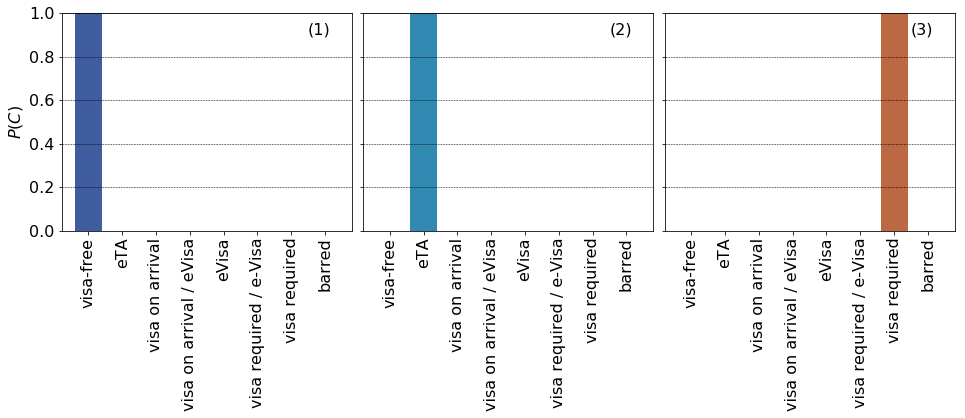

In [49]:
# === T O  H I D E

fig, axes = plt.subplots(1,3, sharex = True, sharey = True, gridspec_kw = {'wspace' : 0.04, 'hspace' : 0.04})
fig.set_size_inches(16,4)
for idx, ax in enumerate(axes.flat):
    if idx == 0:
        ax.bar(range(nc), [1,0,0,0,0,0,0,0], color = cat_colors)
        ax.text(6.5, 0.9, '(1)', fontsize = 16)
        ax.set_ylabel(r'$P(C)$')
    elif idx == 1:
        ax.bar(range(nc), [0,1,0,0,0,0,0,0], color = cat_colors)  
        ax.text(6.5, 0.9, '(2)', fontsize = 16)
    elif idx == 2:
        ax.bar(range(nc), [0,0,0,0,0,0,1,0], color = cat_colors)
        ax.text(6.5, 0.9, '(3)', fontsize = 16)
        
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
#
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)

plt.show()

The $L_{p}$ distances between any two distributions are equal. However, we feel that **(1)** is closer to **(2)** than  to **(3)** for _visa free_ is closer to _ETA_ than to _visa required_. In general, when comparing probability distributions over ordered categorical variables it is advantageous to use a distance that represets the underlying ordering. One such function is the [_earth mover's distance_](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/rubner-jcviu-00.pdf) (EMD) or [_Wasserstein metric_](https://en.wikipedia.org/wiki/Wasserstein_metric). It is the minimum work required to move one distribution to match and other one, in a nutshell. Before we calculate EMDs for the countries two notes are in order:

* The two dimensional nature of the reciprocity matrix is taken into account by generating a 2D ground distance matrix. For the details please see `calc_ground_distance_2d` in the appendix. 
* The hiearchical clustering matches pairs of distributions with gradually increasing $L_{2}$ distance. As a consequence, the above effect is mitigated to some extent, for the widely dissimilar vectors are unlikely to be paired.

The ground distance matrix is calculated:

In [50]:
# === T O  H I D E

def calc_ground_distance_2D(N):
    """
    Calculates the 2D Manhattan distance for a N*N grid. It returns the flattened 2D distance matrix
    d(ij,kl) = |i - j| + |k - l| (4D)
    Let: m = i * N + j and n = k * N + l
    Let D \in N^{n^2, n^2}
    Then D(n,m) = d(n//N, mod(n,N), m//N, mod(m,N)) = d(ij, kl)
    Parameters:
        N (int) : gridsize
    Returns:
        dmat (np.ndarray[:,:] dtype = np.int) : the flattened Manhattan distance matrix
    """
    
    i_arr = np.repeat(np.arange(N, dtype = np.int), N)
    j_arr = np.tile(np.arange(N, dtype = np.int), N)
    
    dmat = np.abs(np.subtract.outer(i_arr,i_arr)) + np.abs(np.subtract.outer(j_arr, j_arr))
    
    return dmat   

In [51]:
d_ground = calc_ground_distance_2D(8)

The matrix below is the ground distance between two flattened reciprocity matrix. The $(m,n)$-th element is the $L_{1}$ distance between

$$
\big(i \leftarrow \lfloor \frac{m} {n_{c}} \rfloor, j \leftarrow \text{mod}(m, n_{c})\big) \text{ and } \big(k \leftarrow \lfloor \frac{n} {n_{c}} \rfloor, l \leftarrow \text{mod}(n, n_{c})\big)
$$

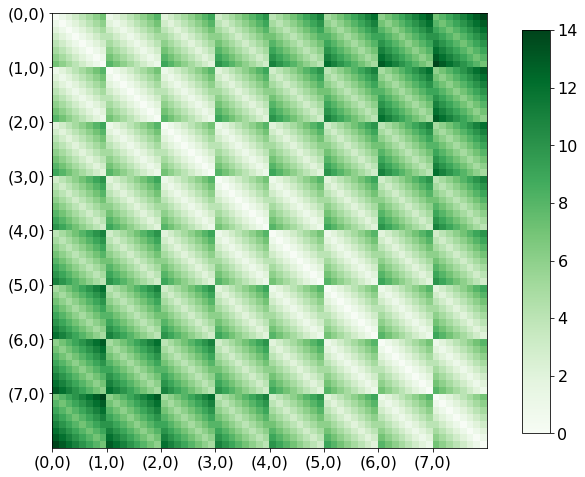

In [52]:
# === T O  H I D E

fig, ax  = plt.subplots(1,1)
fig.set_size_inches((8,8))
im = ax.imshow(d_ground, interpolation = None, cmap = 'Greens', vmin = 0.0, vmax = 14)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax = cbar_ax)
ax.set_xticks([-0.5, 7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5])
ax.set_xticklabels( ['(0,0)', '(1,0)', '(2,0)', '(3,0)', '(4,0)', '(5,0)', '(6,0)', '(7,0)'])
ax.set_yticks([-0.5, 7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5])
ax.set_yticklabels( ['(0,0)', '(1,0)', '(2,0)', '(3,0)', '(4,0)', '(5,0)', '(6,0)', '(7,0)'])
plt.show()

We can now calculate the EMD, `emd`, for all pairs of countries using the [`Python Optimal Transport` module](http://pot.readthedocs.io/en/stable/index.html). We also calculate the Euclidean distance, `l2d`, for comparison.

In [53]:
import ot
emd = scd.squareform(scd.pdist(cnt_recip_mat, lambda x, y: ot.emd2(x, y, d_ground)))
l2d = scd.squareform(scd.pdist(cnt_recip_mat))

It is readily seen from the joint plot below that the earth mover's distance is usually larger than the ordinary $L_{2}$ distance. This is due to taking the distance between the ordered categories into account. 

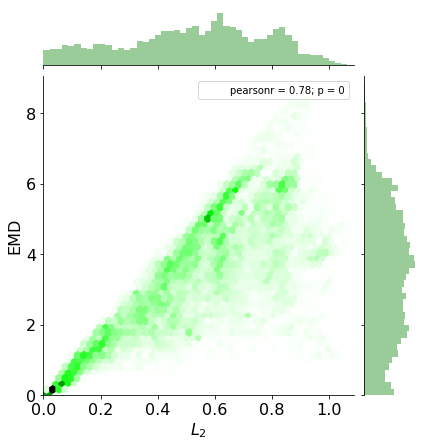

In [54]:
# === T O  H I D E

ax = sns.jointplot(np.ravel(l2d), np.ravel(emd), kind = 'hex', color = 'green')
ax.set_axis_labels(r'$L_{2}$', 'EMD')
plt.show()

Two hierarchical clusterings are generated, one for EMD and one for $L_{2}$ distance.

In [55]:
Z_emd = linkage(emd, 'ward') 
Z_l2d = linkage(l2d, 'ward')

The EMD is an order of magnitude larger than the $L_{2}$ distance, due to the underlying ground distance. The distribution of merge heights also differ. The $L_{2}$ metric generates are more branched structure at at larger heights.

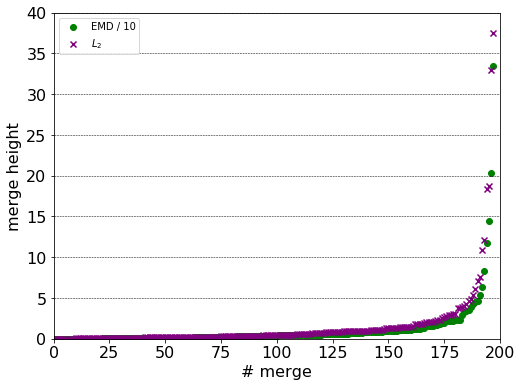

In [56]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.scatter(range(ng-1), Z_emd[:,2] / 10, color = 'green', label = 'EMD / 10')
ax.scatter(range(ng-1), Z_l2d[:,2], color = 'purple', marker = 'x', label = r'$L_{2}$')
ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
ax.set_xlim((0, 200))
ax.set_ylim((0, 40))
ax.set_xlabel('# merge')
ax.set_ylabel('merge height')
ax.legend()
plt.show()

The labels in the top forty clusters are compared with respect to the induced [Fowlkes-Mallows score](https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index). The closer its value to unit, the more labels can be found grouped in the same clusters in the two hierarchy.

In [57]:
label_pairs = ((linkage_to_labels(Z_emd, n), linkage_to_labels(Z_l2d, n)) for n in range(1,40))
scores = list(fowlkes_mallows_score(*lp) for lp in label_pairs)

The score is unit when all countries are in a single cluster as expected. It plummets just below 0.6 indicating the topmost merge partitions the countries quite differently. The next lower merges increase the value of the score, so that the countries within the top two clusters are grouped into similar clusters. This jaggedy behaviour is due to the EMD and $L_{2}$ distance being correlated. In case of two independent partitionings, the score is expected to monotonically decrease.

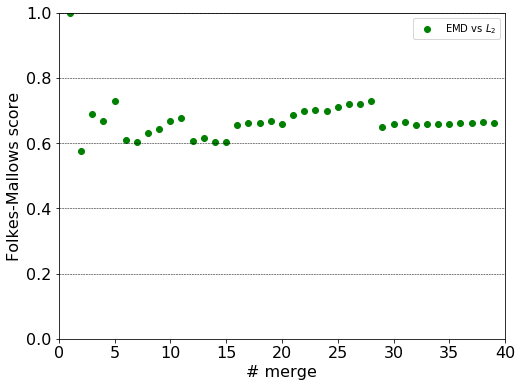

In [58]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.scatter(range(1,40), scores, color = 'green', label = 'EMD vs $L_{2}$')
ax.yaxis.grid(color = 'black', linestyle = '--', linewidth = 0.5)
ax.set_xlim((0, 40)); ax.set_ylim((0, 1));
ax.set_xlabel('# merge'); ax.set_ylabel('Folkes-Mallows score');
ax.legend()
plt.show()

Back to the EMD clustering: where to cut the dendrogam? For there is no apparent gap (or elbow) in the succession of merge heights, the silhouette method will be invoked.

In [59]:
label_gen = (linkage_to_labels(Z_emd, n) for n in range(2,40))
score_gen = (silhouette_score(emd, label, metric = 'precomputed') for label in label_gen)
scores = np.fromiter(score_gen, dtype = np.float)

n_clusters = np.argmax(scores) + 2
print("Silhouette maximum at number of clusters: {0}".format(n_clusters))

Silhouette maximum at number of clusters: 5


The tree thus will be cut to yield five clusters. The means of the reciprocity matrices within each cluster are shown below. The first three roughly correspons to the (_visa required, visa on arrival_), (_visa required, visa requiredl_), (_visa free_, _visa free_) relationships. The fourth group collates countries that are less welcoming than welcomed. The fifth represents a group of countries which either have mutual _visa free_ arrangements or being demanded _visa required_. 

In [60]:
clustaz_ = split_at_n_top(Z_emd, 5)
means_ = np.array([np.mean(cnt_recip_mat[_v], axis = 0) for _k, _v in clustaz_.items()])

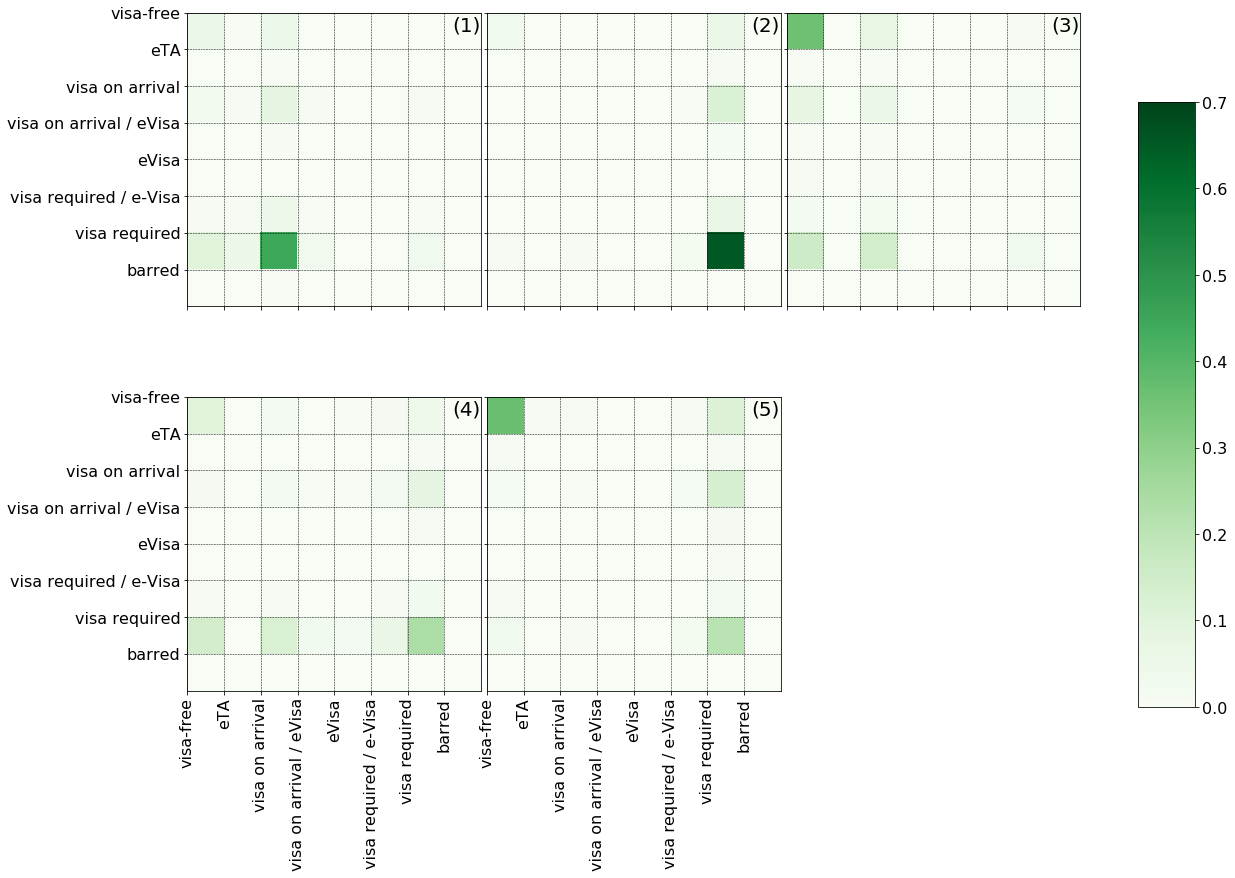

In [61]:
# === T O  H I D E

fig, axes = plt.subplots(2, 3, sharex = True, sharey = True, gridspec_kw = {'wspace' : 0.02, 'hspace' : 0.02})
fig.set_size_inches(16,14)
for idx, (mean_, ax) in enumerate(zip(means_, axes.flat)):
     
    im  = ax.imshow(mean_.reshape(8,8), cmap = 'Greens', vmin = 0, vmax = 0.7)
    ax.set_adjustable('box-forced')
    
    ax.set_xticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
    ax.set_yticks([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
  
    ax.set_xticklabels(category_lookup.values(), rotation = 90)
    ax.set_yticklabels(category_lookup.values())
    
    ax.xaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    
    label = "({0})".format(idx + 1)
    ax.text(6.7, 0, label, fontsize=20)
     
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.6])
fig.colorbar(im, cax = cbar_ax)

axes[-1][-1].axis('off')   
plt.show()

The dendrogram of the five clusters is shown below in anticloskwise order.

show picture

### Asymmetry 

Next, we calcaulte the conditional distribution of requirements with respect to the exit requirements. This is easily achieved by normalising each row of the overall reciprocity matrix.

In [62]:
p_recip_mat = recip_mat / np.sum(recip_mat, axis = 0)

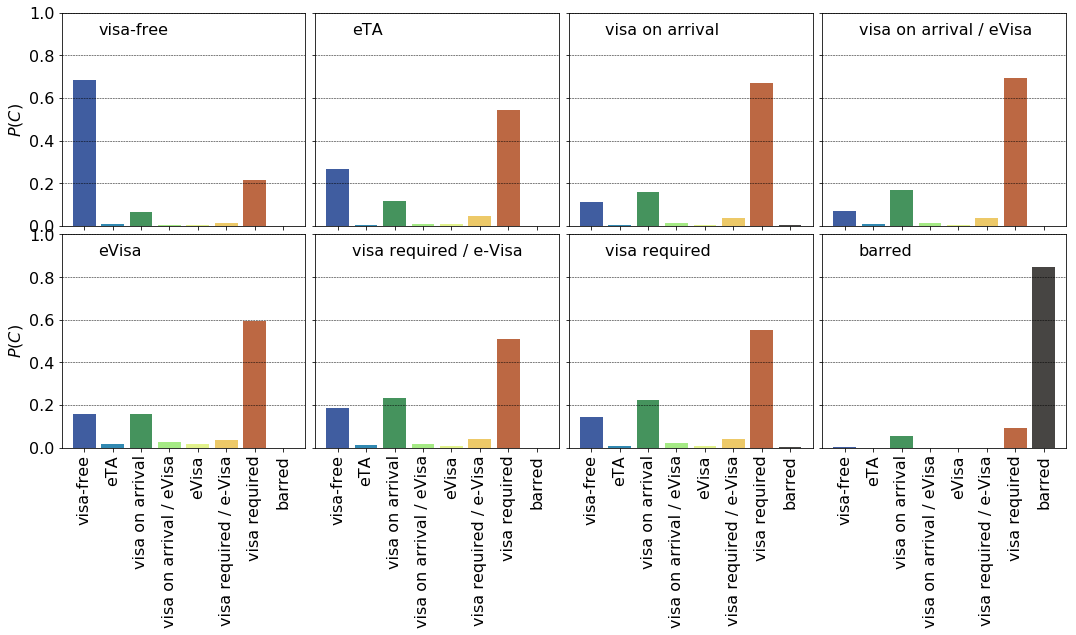

In [63]:
# === T O  H I D E

fig, axes = plt.subplots(2,4, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.04, 'wspace' : 0.04})
fig.set_size_inches(18,8)

for idx, (row, ax) in enumerate(zip(p_recip_mat.T, axes.flat)):
 
    ax.set_ylim((0,1))
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.set_xticks(range(nc))
    ax.set_xticklabels(category_lookup.values(), rotation = 90)  
    ax.bar(range(nc), row, color = cat_colors)
    ax.text(0.5, 0.9, category_lookup[idx], fontsize = 16)
axes[0,0].set_ylabel(r'$P(C)$')
axes[1,0].set_ylabel(r'$P(C)$')
plt.show()

From these probability plots one can deduce that _visa free_ and _visa on arrival_ requirements are the mostly reciprocated ($p_{0,0}= 0.7, p_{7,7} = 0.55$). Countries also tend to mutally bar each other's citizen's ($p_{8,8} = 0.95$). At least there is something they agree on. 

#### Quatifying reciprocity of a country

To see much a country's entry requirements reciprocated, the overlap between host $v_{i,*}$ and guest $v_{*,i}$ vectors is calculated.

$$
A_{us}(i) = \frac{\sum\limits_{k} \delta(v_{ik},v_{ki})}{n_{g}}
$$

A more sophisticated indicator is the count the sing of the differences, $A_{sg}$. Negative values are assigned to counries that are more welcoming than welcomed.

$$
A_{sg} = \frac{\sum\limits_{k} \text{sign}(v_{ik} - v_{ki}) } {n_{g}}
$$

A third measure of asymetry is the signed sum of differences, $A_{ss}$. However, the assignment of the actual numerical values to the categories, apart from being ordered, is somewhat accidental.

$$
A_{ss} = \frac{\sum\limits_{k} v_{ik} - v_{ki} } {n_{g} \cdot (\max(C) - \min(c)) }
$$

In [64]:
# A_{us} -- unsigned overlap
a_unsigned = np.fromiter((np.sum(g == h) for g, h in zip(V, V.T)), count = ng, dtype = np.float) / ng
# A_{sg} -- signed difference
a_signed = np.fromiter((np.sum(np.sign(h - g)) for h, g in zip(V, V.T)), count = ng, dtype = np.float) / ng
# A_{ss} -- sum of signed difference
a_signed_sum = np.fromiter((np.sum(h - g) for h, g in zip(V, V.T)), count = ng, dtype = np.float) / ng / 7

df_cnt_stats['unsigned'] = a_unsigned 
df_cnt_stats['signed'] = a_signed
df_cnt_stats['signed sum '] = a_signed_sum 

The three most welcomed country:

In [65]:
df_cnt_stats.sort_values(by=['signed'])[['name', 'signed', 'unsigned']].head(3)

,name,signed,unsigned
186,UNITED STATES OF AMERICA,-0.814070,0.185930
28,CANADA,-0.768844,0.201005
9,AUSTRALIA,-0.572864,0.035176


The three least welcomed countries:

In [66]:
df_cnt_stats.sort_values(by=['signed'])[['name', 'signed', 'unsigned']].tail(3)

,name,signed,unsigned
163,SOMALIA,0.788945,0.110553
33,COTE D'IVOIRE,0.824121,0.115578
73,HAITI,0.869347,0.120603


The sorted scores are shown below. The flatter regions indicate that numerious countries have similar asymetric relations. However, looking at just $A_{us}$ and $A_{sg}$ does tell us whether the asymmetries of different signs compensate each other or a country has symmetric relationships.

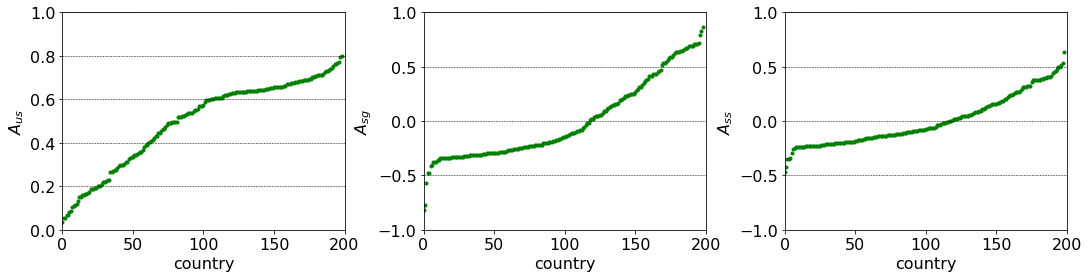

In [67]:
# === T O  H I D E

labels_ = [r'$A_{us}$', r'$A_{sg}$', r'$A_{ss}$']
data_sets_ = (a_unsigned, a_signed, a_signed_sum)   

fig, axes = plt.subplots(1,3, subplot_kw = {'ylim' : (-1.0, 1.0), 'xlim' : (0.0, 200.0)} , figsize = (16,4), 
                         gridspec_kw = {'wspace' : 0.28})

fig.set_size_inches(18,4)
for data_, label_, ax in zip(data_sets_, labels_, axes):
    ax.scatter(range(ng), np.sort(data_), marker = '.', c = 'green')
    ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
    ax.set_ylabel(label_)
    ax.set_xlabel('country')
axes[0].set_ylim((0.0,1.0))
plt.show()

A joint plot of $A_{us}$ and $A_{sg}$ can resolve this issue.  The more asymmetric a country is  the more likely it is more less welcomed then welcoming. These countries constitute top left cluster. If a country has symmetric relationships, ($A_{us}$) close to zero, it is likely to be less welcoming than welcomed according to the grouping in the bottom right corner.

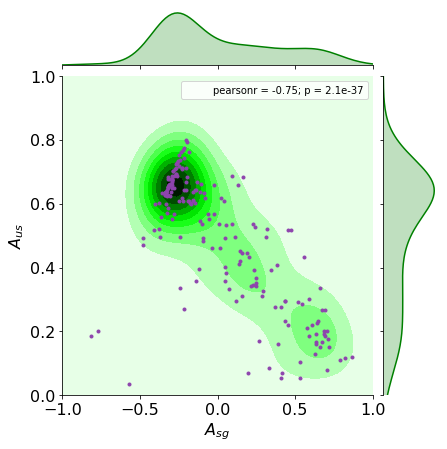

In [68]:
# === T O  H I D E

ax = sns.jointplot(a_signed, a_unsigned, kind = 'kde', color = 'green', xlim = (-1, 1.0), ylim = (0.0, 1.0))
ax.x = a_signed; ax.y = a_unsigned;
ax.set_axis_labels(r'$A_{sg}$', r'$A_{us}$')
ax.plot_joint(plt.scatter, marker = '.', c = '#8E44AD')
plt.show()

### Blocks


It is interesting to see whether there are groups of countries which have stronger ties among themselves than with others. An extreme example is a group where all entry requirements are _visa free_ in both directions.

To this end consider the directted graph where the vertices are the countries; each of them connected by two directed edges corresponding to the entry requirements. We then color the edges according to their types _e.g._ Holy See and Italy are connected by two antiparallel _blue_ edges. Finding a group of identical entry requirements is then equvalent to finding the n-cliques containing only edges of the same colour.

This can be done in the following way:

$$ \begin{eqnarray} & & \textbf{Algorithm:} \textit{Find maximum disjoint coloured cliques} \\
&. & \quad \texttt{FMDCC}(G, c) \\
&. & \quad G' \leftarrow \left(V, G(E)  \setminus \{v_{ij} \in G(E): \,\, 
\texttt{Colour}(v_{ij}) \neq \texttt{Colour}(v_{ji}) \} \right) \\ 
&. & \quad G' \leftarrow \left(V, G(E)  \setminus \{v_{ij} \in G(E): \,\, 
 \texttt{Colour}(v_{ij}) \neq c\} \right) \\ 
&. & \quad \mathbf{Blocks} \leftarrow () \\
&. & \quad \mathbb{S} \leftarrow \texttt{FindDisjointSubgraphs}(G') \\
&. & \quad \textbf{for} \,S \in \mathbb{S}  \textbf{ do} \\
&. &  \quad \quad \textbf{while} \, |S| > 0 \, \textbf{do} \\
&. & \quad \quad \quad  C \leftarrow \texttt{FindMaximumClique}(S) \\
&. & \quad \quad \quad \mathbf{Blocks}.append( C)  \\ 
&. & \quad \quad \quad S \leftarrow S \setminus C \\ 
&. & \quad \quad \textbf{end while} \\ 
&. & \quad \textbf{end do} \\ 
\end{eqnarray} $$

In [69]:
# === T O  H I D E

def find_colour_max_cliques(X, colour):
    """
    Finds the maximum disjoint cliques with edges of identical colour in a graph.
    Parameters:
        A (np.ndarray) : adjacency matrix containing the colours for each edges
        colour (int) : index of the colour. Be careful when using 0 as colour index!
    Returns:
        max_cliques ([[int]]) : list of node indices in the maximum cliques
    """
    # choose colour
    colour = colour # visa free

    # Create adjacency matrix, connected (True) if entry and exit requirements are identical
    A = (X == colour) & ((X - X.T) == 0)

    # generate a graph
    G = nx.from_numpy_matrix(A)

    # find disjoint subgraphs
    groups =(G.subgraph(c).copy() for c in nx.connected_components(G))

    # remove singleton clusters
    groups  = filter(lambda x: x.order() > 1, groups)

    max_cliques = []
    
    for group in groups:
        # find maximum clique and remove  
        # this is really inefficient...
        while group.order() > 0:
            cliques = list(nx.find_cliques(group))
            cliques.sort(key = len)                  # find maximum clique 
     
            if len(cliques[-1]) > 1:                 # ignore singletion cliques  
                max_cliques.append(cliques[-1])
                
            group.remove_nodes_from(cliques[-1])     # remove maximum clique
                  
    return max_cliques

In [70]:
# === T O  H I D E

def _bezier(pos_start, post_end, pos_control, n_points):
    """
    Calculates the quadratic Bezier curve given the points.
    """
    t = np.linspace(0, 1, num = n_points)[:,None]
    s = (1.0 - t)  
    pos = s * (s * pos_start + t * pos_control) + t * (s * pos_control + t * post_end)
    pos = pos.T

    return pos

def _set_circle_positions(start_angle, n_points):
    """
    Calculates the coordinates of a given number of points on the unit circle
    Parameters:
        n_points (int) : number of points
    Returns
        pos (np.ndarray (2, npoints), np.float) : positions of the points.
    """

    angles = np.linspace(start_angle, start_angle + np.pi * 2, num = n_points, endpoint = False)
    pos = np.vstack([np.cos(angles), np.sin(angles)]).T

    return pos

def _set_control_pos(pos_start, pos_end, pos_centre = np.zeros(2, dtype = np.float), scale = 1.0):
    """
    Sets the control point of a quadratic Bezier curve.
    Parameters:
        pos_start (np.ndarray[]) : starting point of the Bezier curve
        pos_end (np.ndarray[]) : end point of the Bezier curve
        pos_centre (np.ndarray[]) : reference point
        scale (float) : sets radius of the arc. 0.0: straight line, R, 1.0: R_{circ}. Default 1.0.
    Returns:
        pos_control (np.ndarray[]) : control point of the Bezier curve
    """
    _mid = (pos_start + pos_end) * 0.50
    pos_control = scale * pos_centre + (1.0 - scale) * _mid 

    return pos_control


class CircoPlot(object):
    """
    Circo graph plotting utility without memory. It uses generators whenever it is possible.    
    """
    
    def __init__(self, n, 
                 ax = None, 
                 edge_colours = 'blue',
                 node_labels = None,
                 node_label_colours = 'blue', 
                 start = 0):
        
        # set order
        self._n = n 
        
        # set edges
        self._edges = None
        
        # set edge colours
        if isinstance(edge_colours, str):
            self._edge_colours = cycle((edge_colours,))
        else:
            try:
                _ = iter(edge_colours)
                self._edge_colours = edge_colours
            except:
                raise TypeError("edge_colours should be str or other iterable. Got: {0}".format(type(edge_colours)))
          
        # get axis
        if ax is None:
            fig, ax = plt.subplots(1,1)
            self._ax = ax
        else:
            self._ax = ax
              
        # set node label colours
        if isinstance(node_label_colours, str):
            self._node_label_colours = cycle((node_label_colours,))
        else:
            try:
                _ = iter(node_label_colours)
                self._node_label_colours = node_label_colours
            except:
                raise TypeError("node_label_colours should be str or other iterable. Got: {0}".format(type(node_label_colours))) 
        
        # set node labels
        self._node_labels = node_labels
        
        # set node positions
        self._start = start * np.pi / 180             
        self._node_positions = _set_circle_positions(self.start, self.n)
     
    # axis to draw on
    @property
    def ax(self):
        return self._ax
    
    # order of graph
    @property
    def n(self):
        return self._n

    # position of first node
    @property
    def start(self):
        return self._start
        
    def add_edges(self, edges):         
        self._edges = edges
        
    def draw(self):
        # --- create Bezier curves for all edges
        
        self._ax.scatter(self._node_positions[:,0], self._node_positions[:,1], 
                         marker = 'o', 
                         color = 'black', 
                         facecolors = 'none')   
        
        # --- draw all adges
        for _is, _it in self._edges:
                       
            if _is == _it: continue
            
            # plot nodes
            pos_start, pos_end = self._node_positions[_is], self._node_positions[_it]
            pos_control = _set_control_pos(pos_start, pos_end, scale = 0.5)
            arc = _bezier(pos_start, pos_end, pos_control, 50)
            
            # plot arc
            self._ax.plot(arc[0], arc[1], color = next(self._edge_colours), linewidth = 0.2)  
         
        # add node labels
        if self._node_labels is not None:
            
            label_positions = self._node_positions * (1.05)
            label_angles = (np.arange(self.n, dtype = np.int) / self.n) * 360
 
            for idx, label in self._node_labels.items():
                
                x, y = label_positions[idx]
                angle = label_angles[idx]
                    
                ax.text(x, y, label, rotation = angle,  rotation_mode = "anchor", 
                        color = next(self._node_label_colours), size = 12 )

(To generate the plots below a fair of amount modestly interesting code is required. All of the functions can be found in the raw jupyter notebook.)

In [71]:
# === T O  H I D E

# returns a list of the list lengths of a nested list
get_list_lengths = lambda x: list(map(lambda y: len(y), x))

# generates consecutive integer lists
generate_consecutive_lists = lambda x, y = count(): list(map(lambda x: list(islice(y, x)), x))

# generates a list of list limits
get_list_limits = lambda x: map(lambda y: (y[0], y[-1] + 1), x)

# generates corner indices for a block
get_corner_idcs = lambda x:  product((x), (x))

# flatten nested lists
flatten_lists = lambda x: list(chain(*x))

The cliques of _visa free_ countries, `cliques_vf` are retrieved as:

In [72]:
cliques_vf = find_colour_max_cliques(V,0)

The blocks are then printed on a circular layout where each node correspond to a country, and each edge represents a mutual _visa free_ requirement. Largest one consists of the Schengen/EEA/European microstates and numerous South American countries. Several Central American (plus a few African) states constitute the second largest group. The ECOWAS member states made up the third block. In general, countries of geopolitical proximity tend to form cliques. However, all connections in a clique should be _visa free_ therefore even one asymmetric relationship can remove an otherwise perfectly connected country. A fine example is Russia, which requires visa from some of the Central Asian republics, therefore it is cannot be in the mainly post Soviet fourth block.

In [73]:
# === T O  H I D E

block_colours = ['blue', 'black']

# increasing indices for blocks
block_sizes = get_list_lengths(cliques_vf)
idcs = generate_consecutive_lists(block_sizes, count())

# all edges in every block excluding self edges and duplicates
vf_all_edges = filter(lambda y: y[0] < y[1], chain(*map(lambda x: product(x,x), idcs)))

# edge colours
get_edge_nums = lambda x: map(lambda x: (x*(x-1)//2), block_sizes)
edge_nums = get_edge_nums(block_sizes)
edge_colours = chain(*([x] * y for x, y in zip(cycle(block_colours), edge_nums))) 

# node labels as a dict
node_labels = (cnt_name_lookup[idx] for idx in flatten_lists(cliques_vf))
node_labels = dict(enumerate(node_labels))

# node label colours
node_label_colours = chain(*([x] * y for x, y in zip(cycle(block_colours), block_sizes)))

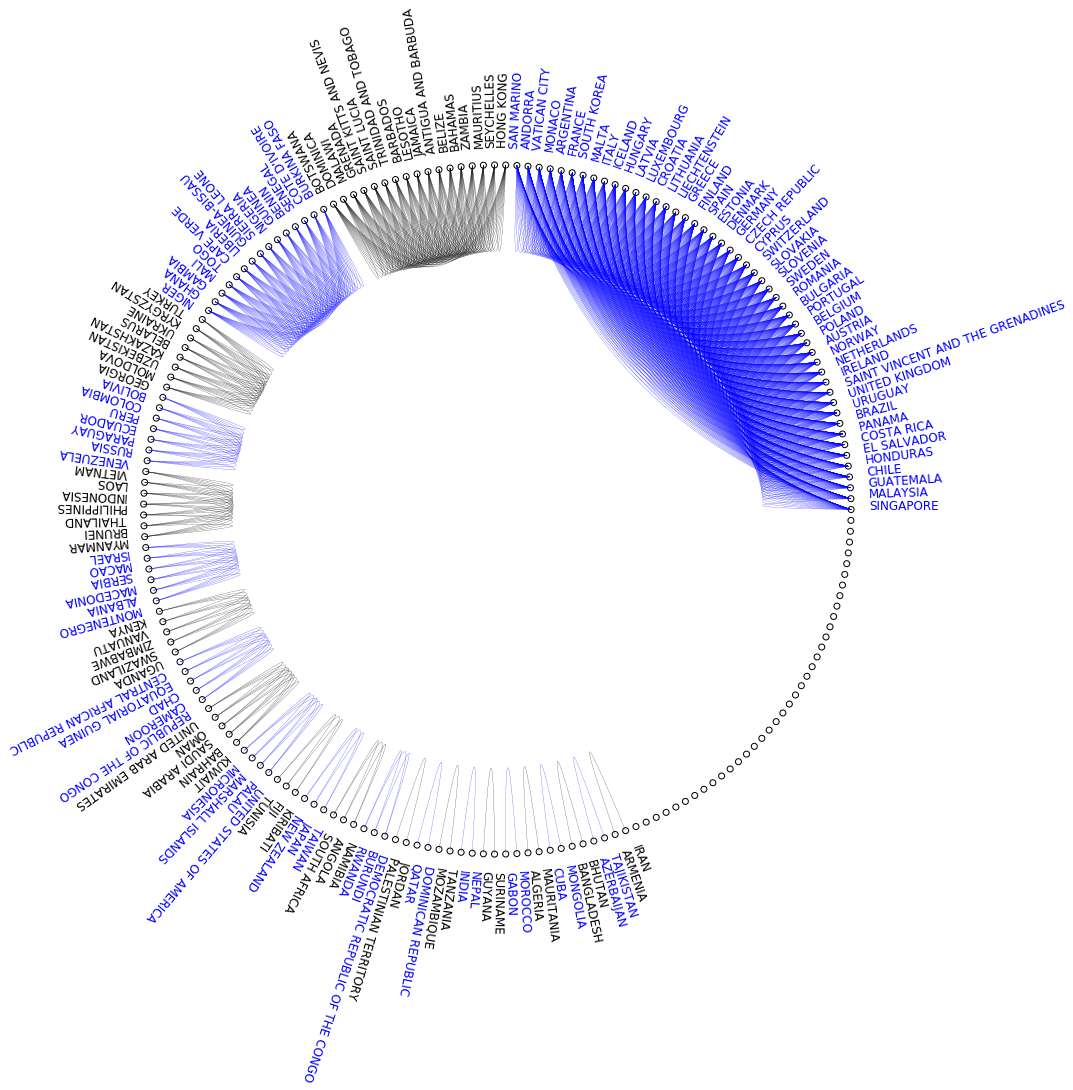

In [74]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(14,14)
ax.axis('off')

cp = CircoPlot(ng, ax = ax, 
               edge_colours = edge_colours,
               node_labels = node_labels, 
               node_label_colours = node_label_colours)

cp.add_edges(vf_all_edges)
cp.draw()
plt.show()

In [75]:
# === T O  H I D E

# block member indices
idcs = np.array(flatten_lists(cliques_vf), dtype = np.int)

# 0. matrix with block lines
raw_idcs = sorted(idcs)
Vsel = V[raw_idcs][:,raw_idcs]
Vsel[Vsel < 0] = 0
# 1. permute countries in to block structure
# permutation (please note it is really memory inefficient)
bm_vf = V[idcs][:, idcs]
bm_vf[bm_vf < 0] = 0          # cosmetics :-(

# 2. sort off block entries for better appearance
# block indices [0, 0, ..., 0, 1, 1, ..., 1, ..., n_block -1, ..., n_block - 1]
idcs = np.repeat(np.arange(len(cliques_vf)), get_list_lengths(cliques_vf))

# get column means by blocks
col_means = np.mean(bm_vf[idcs], axis = 1)

# get array that sorts matrix by block index and column mean
idcs = np.lexsort((col_means, idcs))

# permute block matrix so that the off block colours are arranged 
bm_st_vf = bm_vf[idcs][:,idcs]

In [76]:
# === T O  H I D E

# find out the indices of the block in the new matrix
n_clique_sizes = get_list_lengths(cliques_vf)
idcs = generate_consecutive_lists(n_clique_sizes, count())
c_idcs = get_corner_idcs(list(get_list_limits(idcs)))

# replace block values by mode
bm_mo_vf = np.zeros_like(bm_vf)

for (tr, lr), (tc, lc) in c_idcs:
    bm_mo_vf[tr:lr,tc:lc] = most_common(bm_vf[tr:lr,tc:lc].flat)

In [77]:
# === T O  H I D E

# multiplex
# @TODO add axis specifications and multiple factors
def multiplex(mat, factor = 2):
    """
    Multiplexes a np.ndarray
    Parameters:
        mat (np.ndarray) : at least 2D array
        factor (np.int) : multiplex factor
    Returns:
        mat_new (np.ndarray) : multiplexed matrix
    Examaple:
    a.shape = (n, n) --> b.shape = (factor * n, factor * n)  
    """    
    new_mat = np.repeat(np.repeat(mat, factor, axis = -2), factor, axis = -1)
    
    return new_mat 

In [78]:
# === T O  H I D E

def add_borders(mat, border_positions, border_value, copy = True):
    """
    Add 'borders' to an array at certain values.
    Parameters:
        mat (np.ndarray) : at least 2D array
        border_positions (n) : multiplex factor
    Returns:
        mat_new (np.ndarray) : multiplexed matrix 
    """
    if copy:
        new_mat = np.copy(mat)
    else:
        new_mat = mat
        
    new_mat[border_positions,:] = new_mat[:,border_positions] = border_value
    
    return new_mat

The original matrix, $V$ **(1)** shows no apparent structure. When countries are reordered, the blocks appear along the diagonal. Off-diagonal blocks can also be spotted where the requirements are dominated by a certain category. This is amplified is the mode of each block is plotted **(c)**. The largest _visa free_ clique comprises European and South American countries. Again, it is easier to travel from than to travel to these countries as the leftmost and topmost bands suggests.

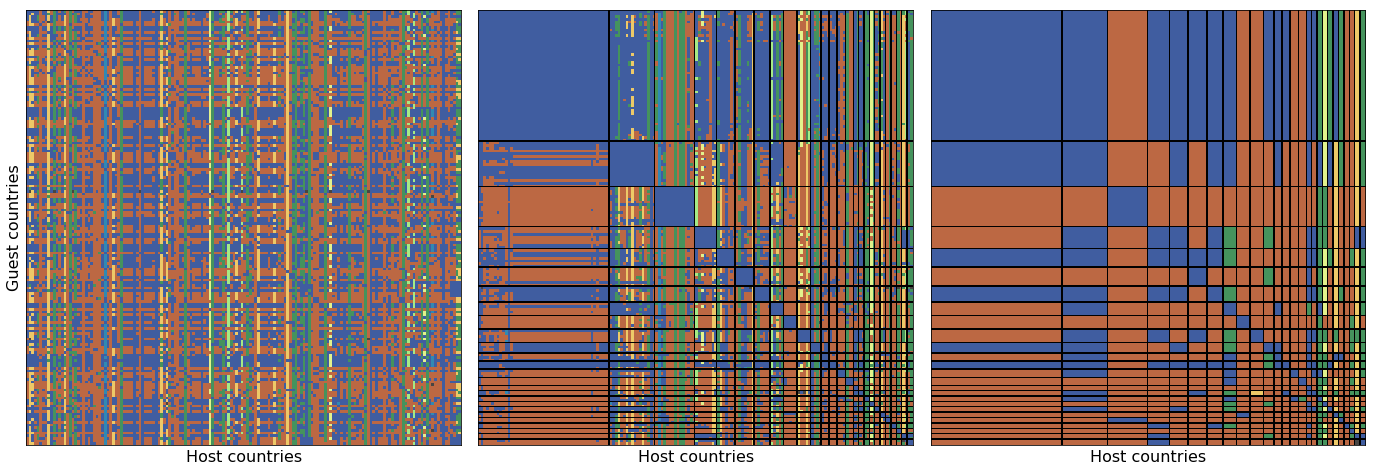

In [79]:
# === T O  H I D E

factor = 2
idcs = generate_consecutive_lists(n_clique_sizes, count())
border_positions = [(x[-1] + 1) * factor - 1 for x in idcs[:-1]] 

matrices = (multiplex(Vsel, factor = factor),
            add_borders(multiplex(bm_st_vf, factor = factor), border_positions, -1),
            add_borders(multiplex(bm_mo_vf, factor = factor), border_positions, -1))


fig, axes = plt.subplots(1,3, sharey = True, gridspec_kw = {'wspace' : 0.04})
fig.set_size_inches(24,24)
cmaps = (cat_cmap, cat_cmap_aug, cat_cmap_aug)

for ax, matrix, cmap in zip(axes, matrices, cmaps): 
    ax.set_adjustable('box-forced')
    ax.imshow(matrix, cmap = cmap)
    ax.set_xticks([], [])
    ax.set_yticks([], [])    
    ax.set_xlabel('Host countries')
axes[0].set_ylabel('Guest countries')
plt.show()

### Requirement similarity

Finally, we compare countries by their country specific requirements. Again, we start with defining a distance. The most striaghtforward choice is the simple matching coefficient, $d_{smc}$ excluding the host and guest countries:

$$
d_{smc}(ij) = \sum\limits_{k\notin \{i,j\}} \delta ( v_{ik}, v_{jk}) \, .
$$

This, however, is not a proper metric and does not take into account the ordering of the categories. The second choice can be the $L_{1}$ distance, again excluding the host and gues countries:

$$
d_{L1} = \sum\limits_{k\notin \{i,j\}} | v_{ik} - v_{jk} | \, .
$$

The drawback of this one, that the numerical values of the ordinal categories are arbitrary. One can use the Jaccard distance over the sets of tuples:

$$
d_{Jac} = \frac{S_{i} \cap S_{j} }   { S_{i} \cup S_{j} }\,\, \text{where }  S_{k} = \{(k, v_{kl}) \},\,\, k\neq l
$$

We will use the $L_{1}$ distance, `masked_l1`, for it reflects the ordering of the categories which is then fed into a hierarchical Ward clustering.

In [80]:
def masked_l1(v1, v2, mask_value = -1):  
    """
    Calculates the L1 distance between two arrays where all elements of specified value are masked.
    Parameters:
        v1, v2 (np.ndarray) : arrays to compare
        mask_value ({np.int, np.float}) : values to ignore
    Returns:
        l1 (np.float) : L1 distance
    """
    mask = (v1 != -1) & (v2 != -1)
    l1 = np.sum(np.abs(v1[mask] - v2[mask]))
    
    return l1

In [81]:
d_l1m = scd.squareform(scd.pdist(V, lambda x, y: masked_l1(x, y)))
Z_l1m = linkage(d_l1m, 'ward')

The histogram of the distances suggest there are at least three clusters (3\*2 / 2). 

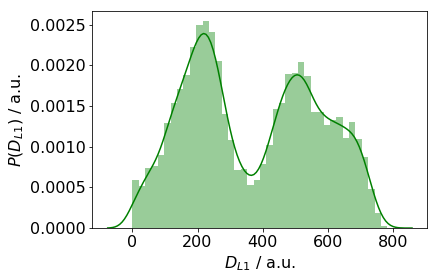

In [82]:
# === T O  H I D E

ax = sns.distplot(d_l1m.flat, kde = True, color = 'green')
#ax.set_xlim((0.0, 1.1))
ax.set_xlabel(r'$D_{L1}$ / a.u.')
ax.set_ylabel(r'$P(D_{L1})$ / a.u.')
plt.show()

The silhouette index assumes it maximum at the topmost merge. However, we choose to add one more split which justified by the density plot above and the large gap between the second and third merges (between 3 and 4 clusters).

In [83]:
label_gen = (linkage_to_labels(Z_l1m, n) for n in range(2,20))
score_gen = (silhouette_score(d_l1m, label, metric = 'precomputed') for label in label_gen)
scores = np.fromiter(score_gen, dtype = np.float)

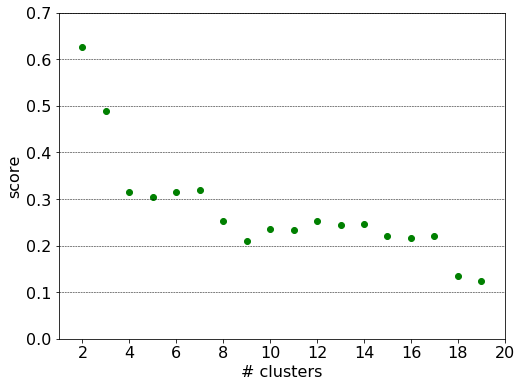

In [84]:
# === T O  H I D E

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.set_xlabel('# clusters')
ax.set_ylabel('score')
ax.set_ylim(0, 0.7)
ax.set_xticks(range(0,24,2))
ax.yaxis.grid(color='black', linestyle = '--', linewidth = 0.5)
ax.scatter(range(2,20), scores, color = 'green')
plt.show()

Again a geopolitical segmentation is readily observed most strikingly in the cases of post Soviet and African states.

In [85]:
# === T O  H I D E

def linkage_matrix_to_ete_tree(X):
    """
    Converts a linkage matrix to an ete phylogenetic tree.
    Parameters:
        X (np.ndarray) : scipy linkage matrix
    Returns:
        tree (ete3.Tree) : phylogenetic tree instance
    """
         
    # get number of nodes and leaves
    n_leaves = X.shape[0] + 1
    node_id_max = 2 * X.shape[0]
    
    # helper function to calculate distance
    set_dist = lambda x, y: y[2] - X[x - n_leaves, 2]  if x >= n_leaves else  y[2]
    
    # create tree with parent node
    tree = ete3.Tree()
    p_node = tree.add_child(name = str(node_id_max))
    
    # populate tree with children
    for idx, merge in enumerate(X[::-1]):
        
        node_id = str(node_id_max - idx)
        p_node = tree&node_id
        
        i1, i2 = int(merge[0]), int(merge[1]) 
        p_node.add_child(name = str(i1), dist = set_dist(i1, merge))
        p_node.add_child(name = str(i2), dist = set_dist(i2, merge))

    return tree

In [86]:
# === T O  H I D E

def format_tree(tree_, clusters, leaf_names, branch_colors, distributions = None):
    
    ts = ete3.TreeStyle()
    ts.show_leaf_name = False
    ts.mode = "c"
    ts.arc_start = 0 # 0 degrees = 3 o'clock
    ts.arc_span = 360
    
    labels = {_vv : _k for _k, _v in clusters.items() for _vv in _v}
    bar_colors = ['#405da0', '#3189b2', '#45935d', '#a5ea85', '#e2f28c', '#edc968', '#bc6843', '#474543']
    
    for idx, node in enumerate(tree_.iter_leaves()):   
        node_id = int(node.name)
        
        # format nodes
        color = branch_colors[labels[node_id]]
        
        ns = ete3.NodeStyle()
        ns["fgcolor"] = color
        ns["vt_line_width"] = 12; ns["hz_line_width"] = 12; 
        ns["vt_line_color"] = color; ns["hz_line_color"] = color;
        node.set_style(ns)
        
        # format ancestors
        for kn in node.iter_ancestors():
            kn.set_style(ns)
        
        # add label to leaves
        text_ = leaf_names[node_id]
        N = ete3.TextFace(text_, fsize = 150, fgcolor = color, tight_text = True, penwidth = 45)
        node.add_face(N, 1, position = "aligned")
        
        # add bar chart to leaves 
        if distributions is not None:
            dist_ = distributions[node_id]
            percentage = [int(x * 100) for x in dist_]
            colors = bar_colors
        
            if idx > 149:
                colors = colors[::-1]; percentage = percentage[::-1]
            barchart = ete3.StackedBarFace(percentage, 500, 150, colors = colors)
            node.add_face(barchart, column = 0, position = "aligned")
          
    return tree_.render(file_name = "%%inline", tree_style = ts, w = 500, h = 500, units = "mm")

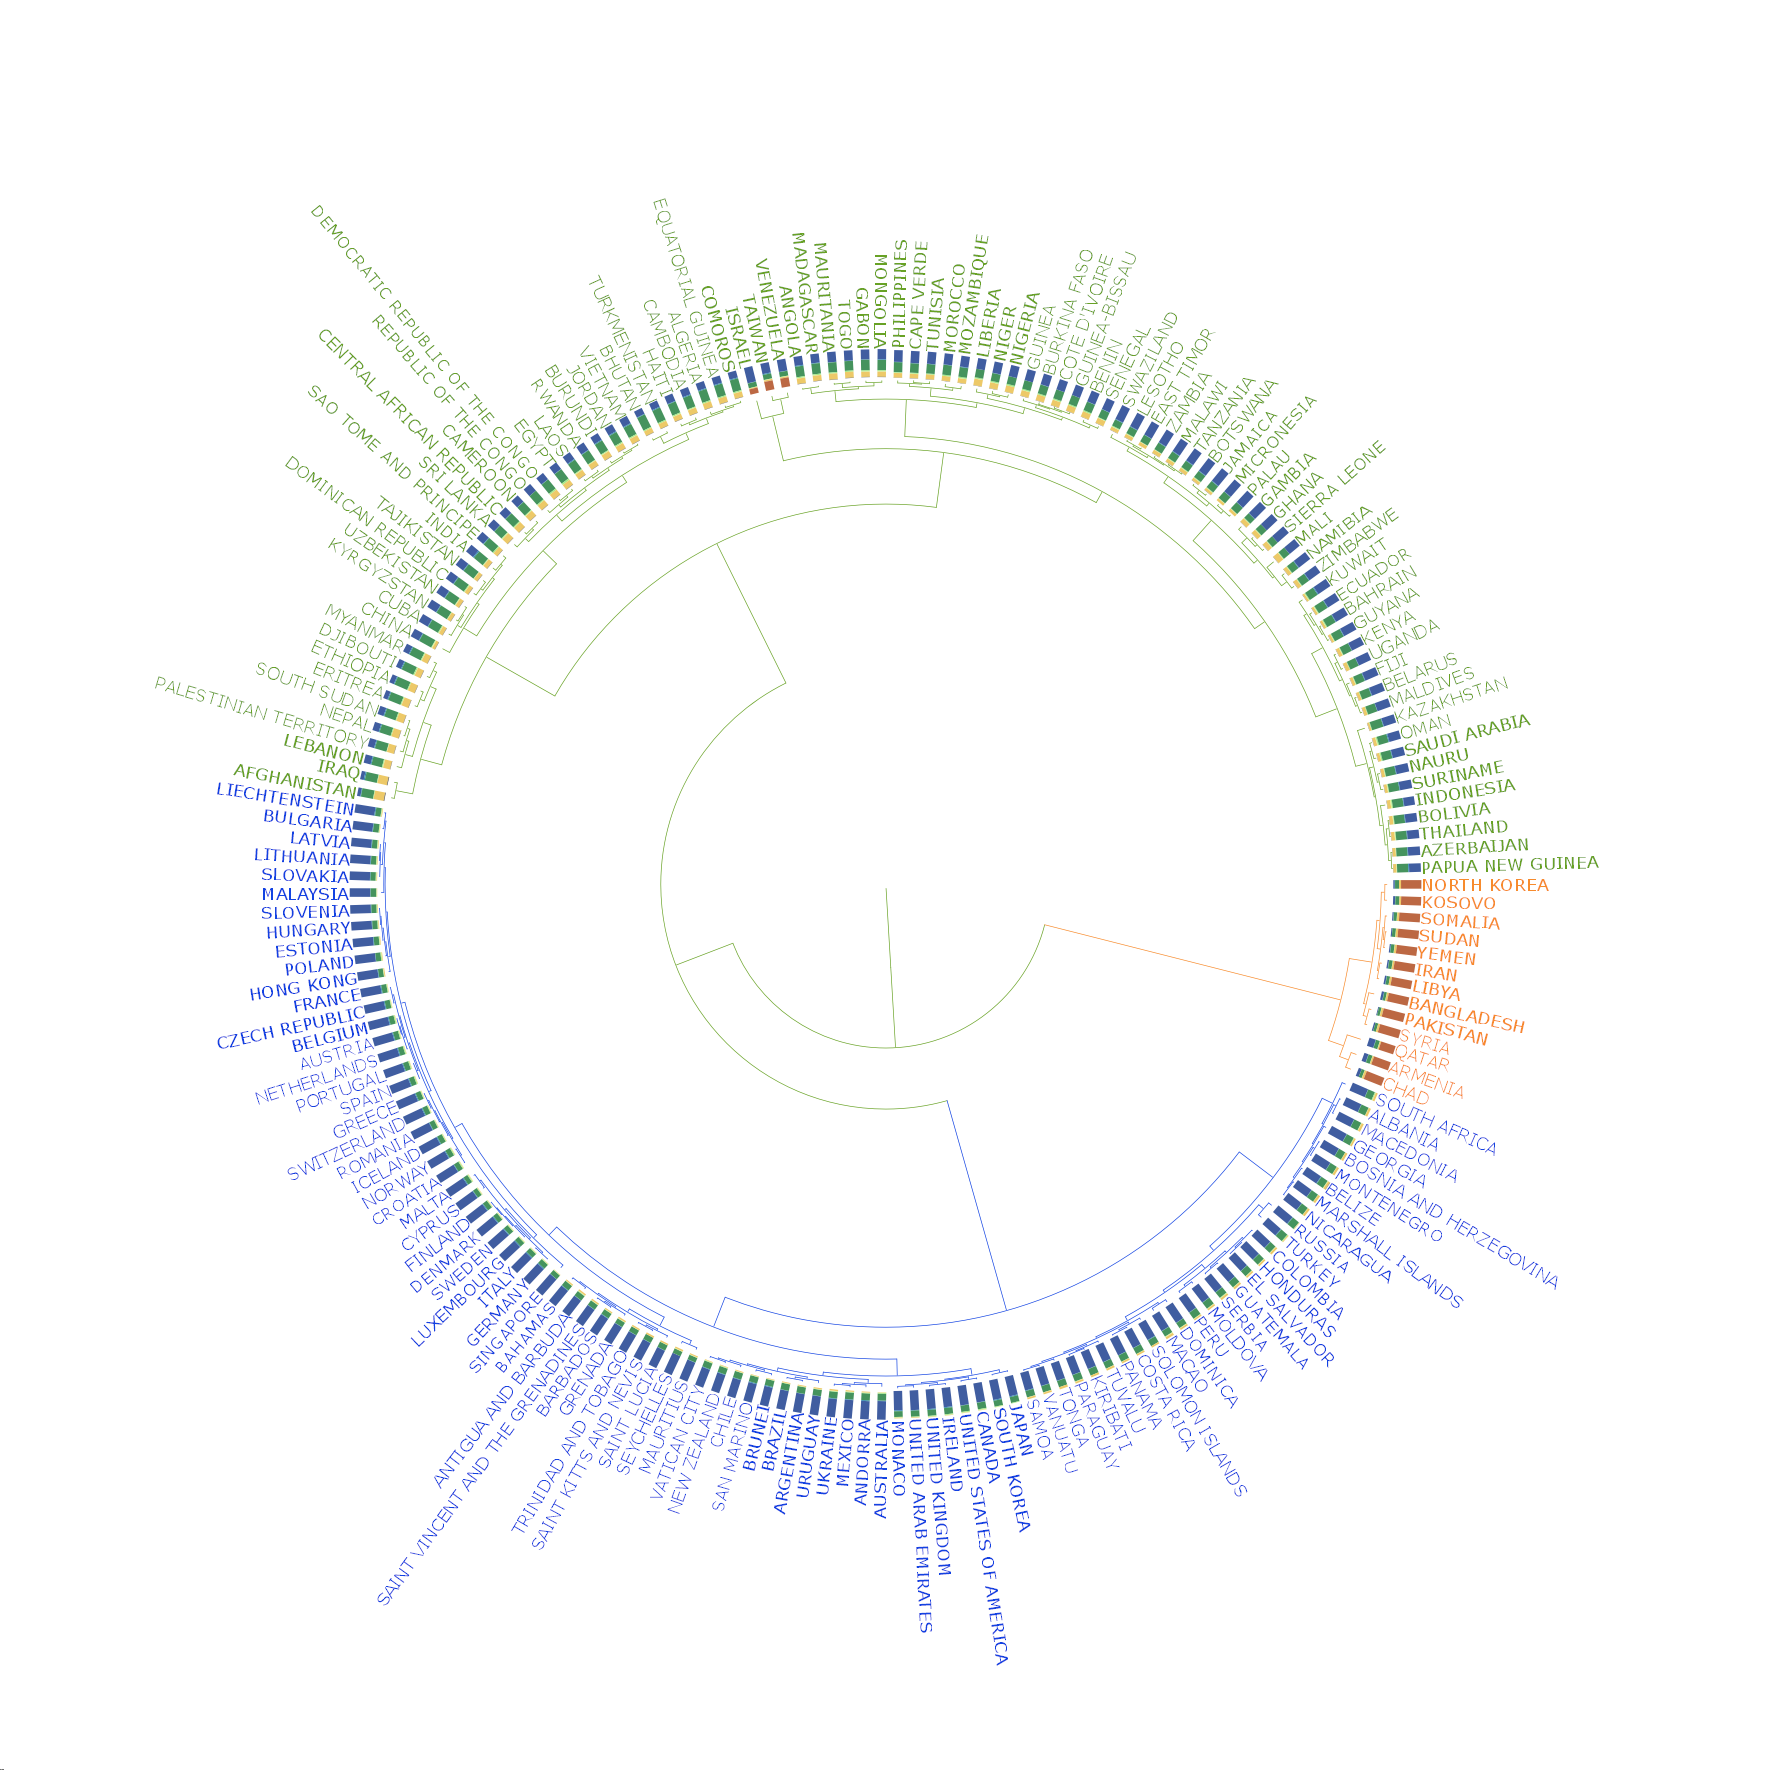

In [87]:
# == T O  H I D E

clusters_ = split_at_n_top(Z, 3)
branch_colors = {1 : '#68a225', 0 : '#1243e2', 2 : '#f78b2d'} 
tree = linkage_matrix_to_ete_tree(Z)
format_tree(tree, clusters_, cnt_name_lookup, branch_colors, distributions = pg)

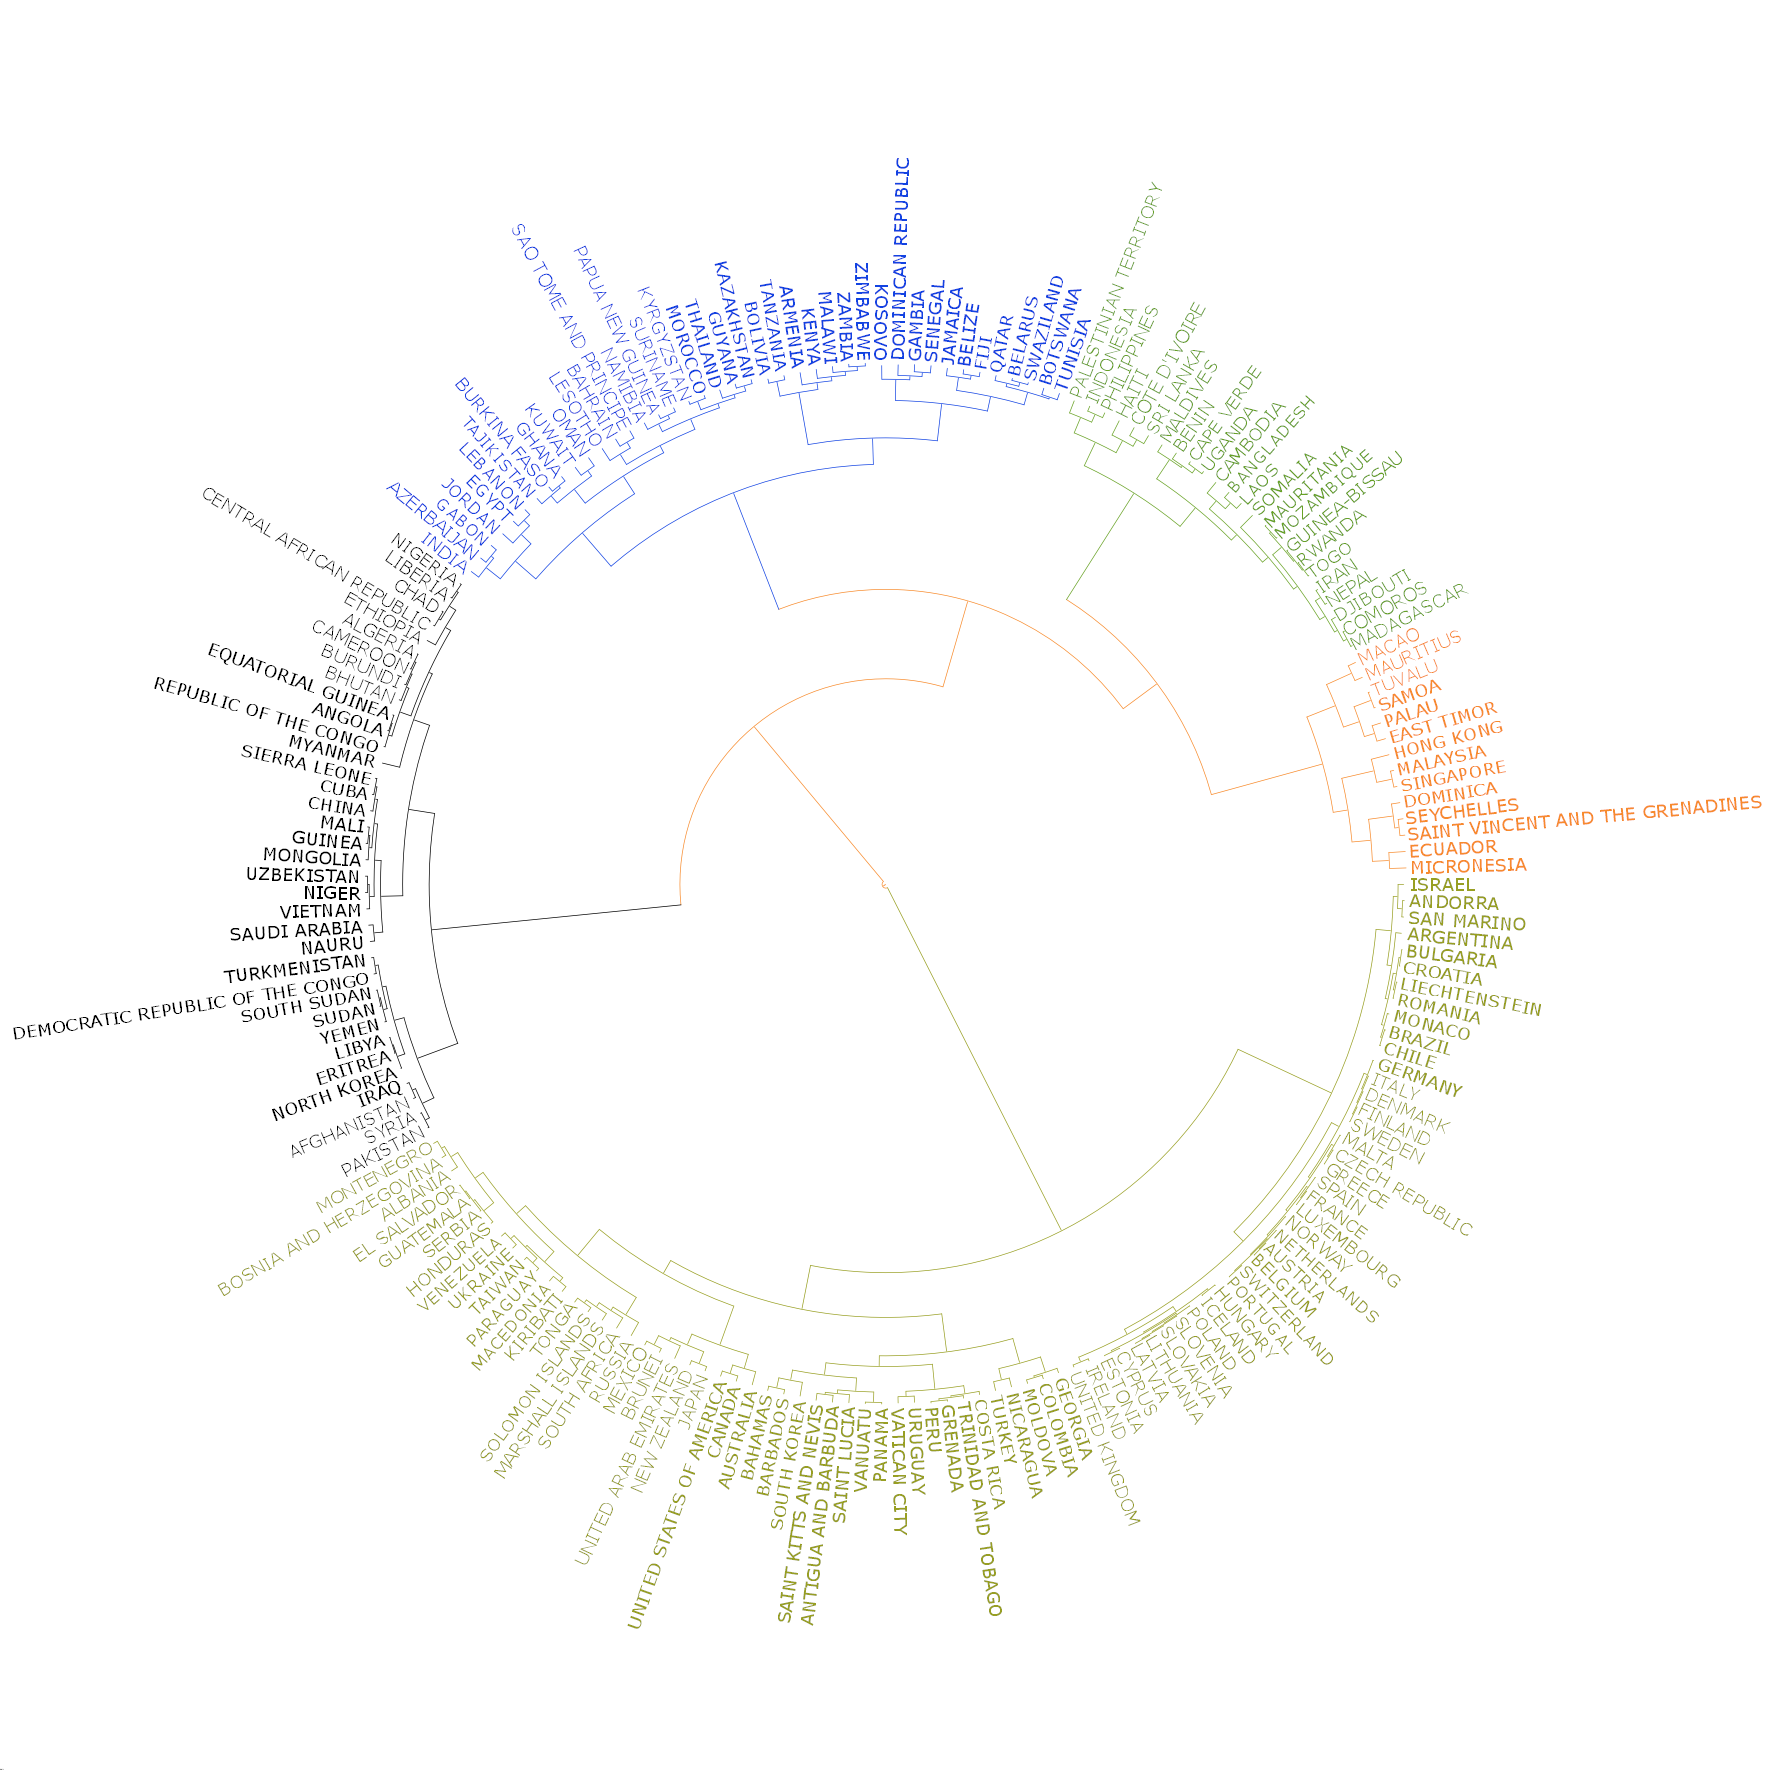

In [88]:
# == T O  H I D E

clusters_ = split_at_n_top(Z_emd, 5)
branch_colors = {0 : '#68a225', 1 : '#52634', 2 : '#f78b2d', 3 : '#1243e2',  4 :'#989f23'}
tree = linkage_matrix_to_ete_tree(Z_emd)
format_tree(tree, clusters_, cnt_name_lookup, branch_colors)

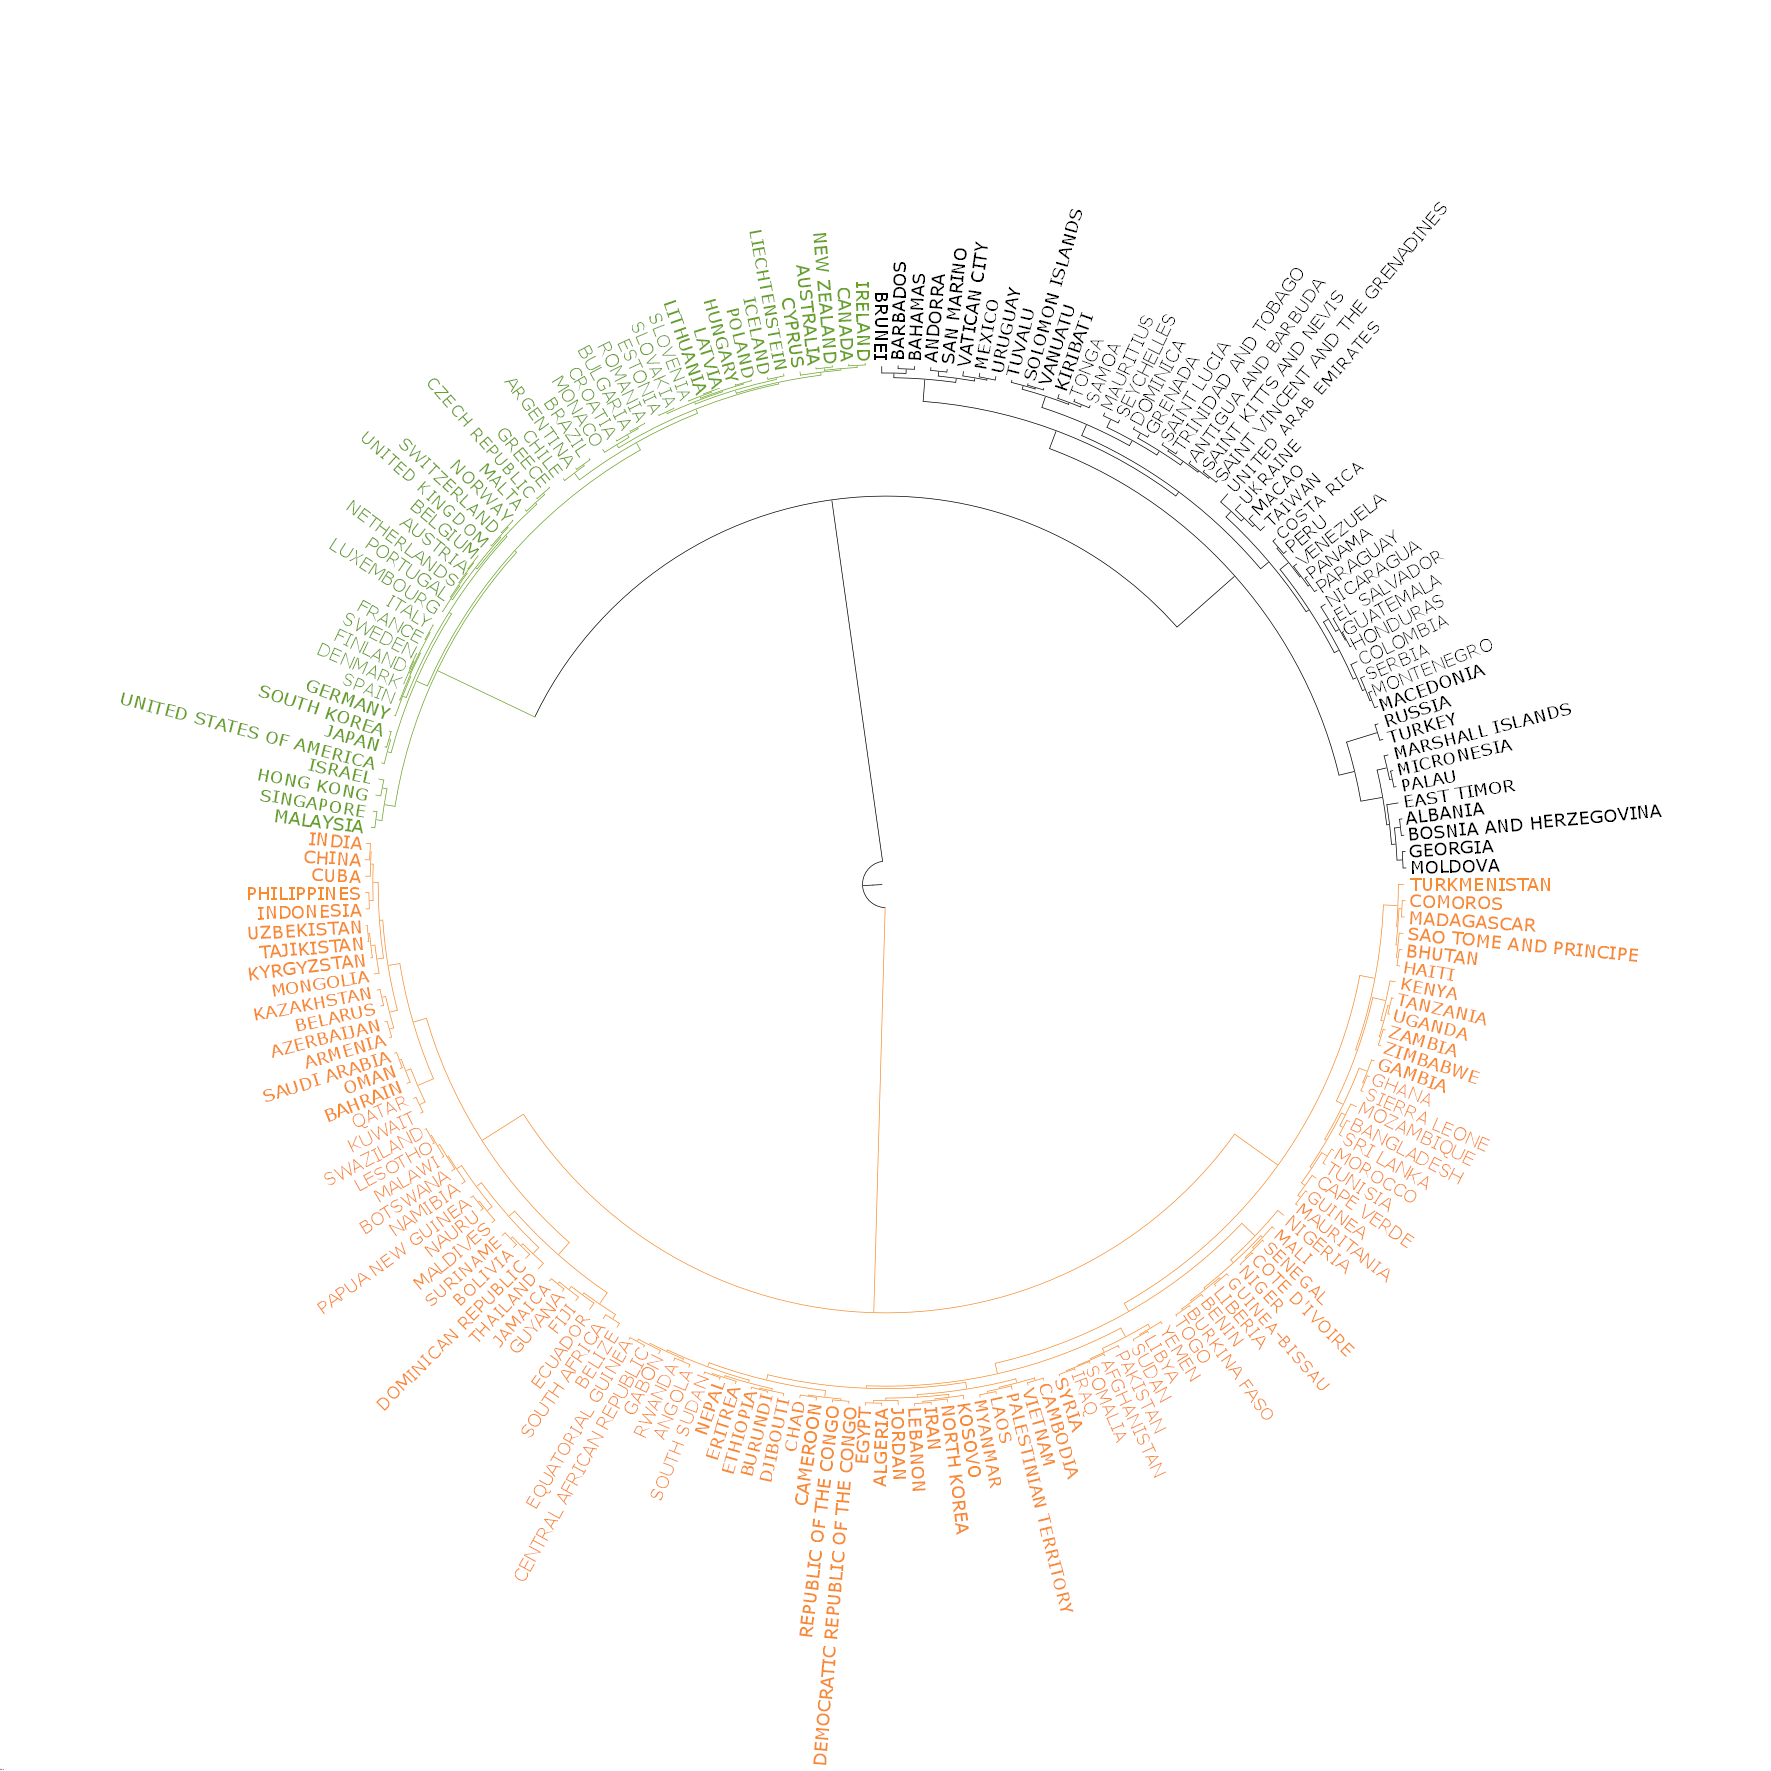

In [89]:
# == T O  H I D E

clusters_ = split_at_n_top(Z_l1m, 3)
branch_colors = {0 : '#68a225', 1 : '#52634', 2 : '#f78b2d'}
Z_l1m[:,2] /= 1000
tree = linkage_matrix_to_ete_tree(Z_l1m)
format_tree(tree, clusters_, cnt_name_lookup, branch_colors)